# Masinsko ucenje - projekat

Dataset: https://archive.ics.uci.edu/ml/datasets/Diabetes+130-US+hospitals+for+years+1999-2008
 
Klasifikacija - Predviđanje ponovne hospitalizacije pacijenta sa dijabetesom na osnovu podataka sa inicijalne hospitalizacije

1.   Priprema podataka

In [1]:
import pandas as pd
import sklearn as scikit
import numpy as np
from sklearn.preprocessing import LabelBinarizer, MultiLabelBinarizer, LabelEncoder
import copy
import matplotlib.pyplot as plt
import category_encoders as ce
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from math import ceil
from sklearn.feature_selection import SelectKBest, SelectPercentile, mutual_info_classif, SelectFromModel, VarianceThreshold

run_long_tasks = True
final_df = True


In [2]:
path = "../dataset/diabetic_data.csv"
dataframe = pd.read_csv(path, low_memory=False, na_values=[
                        "?", "Unknown/Invalid"])
pd.set_option("display.max_columns", None)
dataframe.head()


,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),NaN,6,25,1,1,NaN,Pediatrics-Endocrinology,41,0,1,0,0,0,250.83,NaN,NaN,1,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),NaN,1,1,7,3,NaN,NaN,59,0,18,0,0,0,276,250.01,255,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),NaN,1,1,7,2,NaN,NaN,11,5,13,2,0,1,648,250,V27,6,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),NaN,1,1,7,2,NaN,NaN,44,1,16,0,0,0,8,250.43,403,7,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),NaN,1,1,7,1,NaN,NaN,51,0,8,0,0,0,197,157,250,5,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [3]:
dataframe.shape

(101766, 50)

In [4]:
dataframe["readmitted"].value_counts()

NO     54864
>30    35545
<30    11357
Name: readmitted, dtype: int64

In [5]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   encounter_id              101766 non-null  int64 
 1   patient_nbr               101766 non-null  int64 
 2   race                      99493 non-null   object
 3   gender                    101763 non-null  object
 4   age                       101766 non-null  object
 5   weight                    3197 non-null    object
 6   admission_type_id         101766 non-null  int64 
 7   discharge_disposition_id  101766 non-null  int64 
 8   admission_source_id       101766 non-null  int64 
 9   time_in_hospital          101766 non-null  int64 
 10  payer_code                61510 non-null   object
 11  medical_specialty         51817 non-null   object
 12  num_lab_procedures        101766 non-null  int64 
 13  num_procedures            101766 non-null  int64 
 14  num_

In [6]:
def get_null_col(df, treshold):
    missing = df.isna()
    missing_count = missing.sum()
    total_rows=df.shape[0]
    to_drop = []
    for i in range(0, missing_count.count()):
        if missing_count[i] / total_rows > treshold:
            to_drop.append(i)
    return to_drop

for i in get_null_col(dataframe, 0.1):
    print(dataframe.columns[i])

weight
payer_code
medical_specialty


In [7]:
dataframe["medical_specialty"].fillna("Unknown", inplace=True)
dataframe["payer_code"].fillna("Unknown", inplace=True)
dataframe["weight"].value_counts()

[75-100)     1336
[50-75)       897
[100-125)     625
[125-150)     145
[25-50)        97
[0-25)         48
[150-175)      35
[175-200)      11
>200            3
Name: weight, dtype: int64

In [8]:
weigth_scale_mapper = {
    "[0-25)": 0 
    ,"[25-50)": 1
    ,"[50-75)": 2
    ,"[75-100)": 3
    ,"[100-125)": 4
    ,"[125-150)": 5
    ,"[150-175)": 6
    ,"[175-200)": 7
    ,">200": 8
}
dataframe["weight"].replace(weigth_scale_mapper, inplace=True)
dataframe["weight"].fillna(round(dataframe["weight"].mean()), inplace=True)

In [9]:
print(dataframe.shape)
dataframe.dropna(inplace=True)
to_drop = ["encounter_id",]
dataframe.drop(
    dataframe[to_drop],
    axis=1,
    inplace=True,
)
dataframe.shape

(101766, 50)


(98052, 49)

In [10]:
def get_one_value_cols(df):
    to_drop=[]
    for col in df.columns:
        if len(df[col].unique()) == 1:
            print(col)
            to_drop.append(col)
    return to_drop

dataframe.drop(get_one_value_cols(dataframe),axis=1,inplace=True)

examide
citoglipton
metformin-rosiglitazone


In [11]:
print("Number Of Rows In The Original DataFrame:", len(dataframe))
print("Number Of Rows After Deduping:", len(dataframe.drop_duplicates()))

Number Of Rows In The Original DataFrame: 98052
Number Of Rows After Deduping: 98052


In [12]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 98052 entries, 1 to 101765
Data columns (total 46 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   patient_nbr               98052 non-null  int64  
 1   race                      98052 non-null  object 
 2   gender                    98052 non-null  object 
 3   age                       98052 non-null  object 
 4   weight                    98052 non-null  float64
 5   admission_type_id         98052 non-null  int64  
 6   discharge_disposition_id  98052 non-null  int64  
 7   admission_source_id       98052 non-null  int64  
 8   time_in_hospital          98052 non-null  int64  
 9   payer_code                98052 non-null  object 
 10  medical_specialty         98052 non-null  object 
 11  num_lab_procedures        98052 non-null  int64  
 12  num_procedures            98052 non-null  int64  
 13  num_medications           98052 non-null  int64  
 14  numbe

Diagnose mapping http://icd9cm.chrisendres.com/index.php?action=contents

In [13]:
def diag_mapper(value: str) -> int:
    try:
        int_value = int(float(value))
        if int_value <= 139:
            return 'Infectious and Parasitic'
        elif int_value <= 239:
            return 'Neoplasms'
        elif int_value <= 279:
            return 'Metabolic'
        elif int_value <= 289:
            return 'Blood'
        elif int_value <= 319:
            return 'Mental'
        elif int_value <= 389:
            return 'Nervous System'
        elif int_value <= 459:
            return 'Circulatory System'
        elif int_value <= 519:
            return 'Respiratory System'
        elif int_value <= 579:
            return 'Digestive System'
        elif int_value <= 629:
            return 'Genitourinary System'
        elif int_value <= 679:
            return 'Pregnancy'
        elif int_value <= 709:
            return 'Skin'
        elif int_value <= 739:
            return 'Musculoskeletal'
        elif int_value <= 759:
            return 'Congenital'
        elif int_value <= 779:
            return 'Perinatal Period'
        elif int_value <= 799:
            return 'Ill Defined'
        else:
            return 'Injury'
    except ValueError:
        if value[0] == 'V':
            return 'Status'
        else:  # E
            return 'Cause'


dataframe['diag_1_class'] = dataframe['diag_1'].apply(lambda x: diag_mapper(x))
dataframe['diag_2_class'] = dataframe['diag_2'].apply(lambda x: diag_mapper(x))
dataframe['diag_3_class'] = dataframe['diag_3'].apply(lambda x: diag_mapper(x))


In [14]:
glu_scale_mapper = {
    'None': 0,
    'Norm': 1,
    '>200': 2,
    '>300': 3
}
a1_scale_mapper = {
    'None': 0,
    'Norm': 1,
    '>7': 2,
    '>8': 3,
}
class_mapper = {
    'NO':0,
    '<30':1,
    '>30':2
}

one_hot = LabelBinarizer()
lab_enc = LabelEncoder()

dataframe['admission_type_id'] = dataframe['admission_type_id'].astype('category')
dataframe['discharge_disposition_id'] = dataframe['discharge_disposition_id'].astype('category')
dataframe['admission_source_id'] = dataframe['admission_source_id'].astype('category')
dataframe['weight'] = dataframe['weight'].astype('int32')

dataframe['age']=lab_enc.fit_transform(dataframe['age'])
dataframe['gender'] = one_hot.fit_transform(dataframe['gender'])
dataframe['max_glu_serum'].replace(glu_scale_mapper, inplace=True)
dataframe['A1Cresult'].replace(a1_scale_mapper, inplace=True)
dataframe['medical_specialty']=lab_enc.fit_transform(dataframe['medical_specialty'])

lab_coded = ['metformin','repaglinide','nateglinide','chlorpropamide','glimepiride','acetohexamide',
    'glipizide','glyburide','tolbutamide','pioglitazone','rosiglitazone','acarbose','miglitol','troglitazone',
    'tolazamide','insulin','glyburide-metformin','glipizide-metformin','glimepiride-pioglitazone','metformin-pioglitazone'
    ,'diag_1','diag_2','diag_3','payer_code']

for col in lab_coded:
    dataframe[col] = lab_enc.fit_transform(dataframe[col])

dataframe['change'] = one_hot.fit_transform(dataframe['change'])
dataframe['diabetesMed'] = one_hot.fit_transform(dataframe['diabetesMed'])

dataframe['readmitted'].replace(class_mapper, inplace=True)

dataframe.head()

,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,diag_1_class,diag_2_class,diag_3_class
1,55629189,Caucasian,0,1,3,1,1,7,3,15,71,59,0,18,0,0,0,143,77,121,9,0,0,1,1,1,1,1,0,1,1,0,1,1,1,1,0,0,3,1,0,0,0,0,1,2,Metabolic,Metabolic,Metabolic
2,86047875,AfricanAmerican,0,2,3,1,1,7,2,15,71,11,5,13,2,0,1,454,76,763,6,0,0,1,1,1,1,1,0,2,1,0,1,1,1,1,0,0,1,1,0,0,0,1,1,0,Pregnancy,Metabolic,Status
3,82442376,Caucasian,1,3,3,1,1,7,2,15,71,44,1,16,0,0,0,553,95,248,7,0,0,1,1,1,1,1,0,1,1,0,1,1,1,1,0,0,3,1,0,0,0,0,1,0,Infectious and Parasitic,Metabolic,Circulatory System
4,42519267,Caucasian,1,4,3,1,1,7,1,15,71,51,0,8,0,0,0,54,23,86,5,0,0,1,1,1,1,1,0,2,1,0,1,1,1,1,0,0,2,1,0,0,0,0,1,0,Neoplasms,Neoplasms,Metabolic
5,82637451,Caucasian,1,5,3,2,1,2,3,15,71,31,6,16,0,0,0,263,244,86,9,0,0,1,1,1,1,1,0,1,1,0,1,1,1,1,0,0,2,1,0,0,0,1,1,2,Circulatory System,Circulatory System,Metabolic


In [15]:
dataframe_label = dataframe
dataframe_onehot = dataframe.copy(deep=True)
dataframe_onehot_plus = dataframe.copy(deep=True)
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 98052 entries, 1 to 101765
Data columns (total 49 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   patient_nbr               98052 non-null  int64   
 1   race                      98052 non-null  object  
 2   gender                    98052 non-null  int64   
 3   age                       98052 non-null  int64   
 4   weight                    98052 non-null  int32   
 5   admission_type_id         98052 non-null  category
 6   discharge_disposition_id  98052 non-null  category
 7   admission_source_id       98052 non-null  category
 8   time_in_hospital          98052 non-null  int64   
 9   payer_code                98052 non-null  int64   
 10  medical_specialty         98052 non-null  int64   
 11  num_lab_procedures        98052 non-null  int64   
 12  num_procedures            98052 non-null  int64   
 13  num_medications           98052 non-null  int

In [16]:
def df_one_hot(df, columns):
    tmp = pd.DataFrame()
    for col in columns:
        res = one_hot.fit_transform(df[col])
        for val in range(0, len(res[0])):
            new_col = res[:, val]
            tmp_col = pd.DataFrame(
                {col + '(' + str(one_hot.classes_[val])+')': new_col})
            tmp = pd.concat((tmp, tmp_col), axis=1)
    return pd.concat((df.reset_index(drop=True), tmp.reset_index(drop=True)), axis=1, join='inner')

for col in ['diag_1_class', 'diag_2_class', 'diag_3_class','race']:
    dataframe_label[col] = lab_enc.fit_transform(dataframe_label[col])

dataframe_onehot_plus = df_one_hot(dataframe_onehot_plus, ['diag_1_class', 'diag_2_class', 'diag_3_class',
                              'admission_type_id', 'discharge_disposition_id', 'admission_source_id', 'race'])
dataframe_onehot_plus.drop(['diag_1_class', 'diag_2_class', 'diag_3_class', 'admission_type_id',
                      'discharge_disposition_id', 'admission_source_id', 'race'], axis=1, inplace=True)

dataframe_onehot = df_one_hot(dataframe_onehot, ['diag_1_class', 'diag_2_class', 'diag_3_class','race'])
dataframe_onehot.drop(['diag_1_class', 'diag_2_class', 'diag_3_class','race'], axis=1, inplace=True)


print(dataframe_label.shape)
print(dataframe_onehot_plus.shape)
print(dataframe_onehot.shape)

(98052, 49)
(98052, 152)
(98052, 104)


In [17]:
def remove_low_variance_columns(df, target, treshold):

    y = df[target]
    X_cat = df.drop(columns=[target,])
    selector = VarianceThreshold(threshold=treshold)
    X_reduced = selector.fit_transform(X_cat, y)
    cols = selector.get_support(indices=True)
    selected_columns = X_cat.iloc[:, cols].columns.tolist()
    selected_columns.append(target)
    print(X_reduced.shape)
    return selected_columns

In [18]:
def select_best_columns(df, target, best_ratio):

    y = df[target]
    X_cat = df.drop(columns=[target, 'diag_1', 'diag_2', 'diag_3'])
    X = X_cat
    selector = SelectKBest(mutual_info_classif, k=ceil(X.shape[1]*best_ratio))
    X_reduced = selector.fit_transform(X, y)
    cols = selector.get_support(indices=True)
    selected_columns = X.iloc[:, cols].columns.tolist()
    selected_columns.append(target)

    print(X_reduced.shape)

    return selected_columns

2.   Deskriptivna analiza

<AxesSubplot: ylabel='readmitted'>

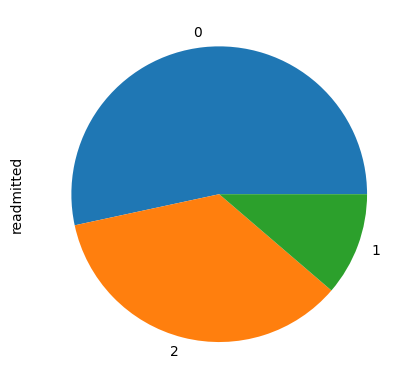

In [19]:
dataframe_onehot['readmitted'].value_counts().plot(kind='pie')

In [40]:
def feature_importance(df,to_drop=['diag_1', 'diag_2', 'diag_3'],):
    target = 'readmitted'
    to_drop.append(target)
    y = df[target]
    X = df.drop(columns=to_drop)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=.2, random_state=1066)
    encoder = ce.LeaveOneOutEncoder(return_df=True)
    X_train_loo = encoder.fit_transform(X_train, y_train)
    X_test_loo = encoder.transform(X_test)
    model = GradientBoostingRegressor(
        learning_rate=0.05, max_depth=5, n_estimators=500, min_samples_split=5, n_iter_no_change=10)
    model.fit(X_train_loo, y_train)

    rmse = np.sqrt(mean_squared_error(y_test, model.predict(X_test_loo)))
    feature_importance = model.feature_importances_
    sorted_idx = np.argsort(feature_importance)
    fig = plt.figure(figsize=(20, 30))
    plt.barh(range(len(sorted_idx)),
             feature_importance[sorted_idx], align='center')
    plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
    plt.title('Feature Importance')

    # perm_importance = permutation_importance(
    #     model, X_test_loo, y_test, n_repeats=10, random_state=1066)
    # sorted_idx = perm_importance.importances_mean.argsort()
    # fig = plt.figure(figsize=(20, 30))
    # plt.barh(range(len(sorted_idx)),
    #          perm_importance.importances_mean[sorted_idx], align='center')
    # plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
    # plt.title('Permutation Importance')

In [21]:
dataframe.head()

,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,diag_1_class,diag_2_class,diag_3_class
1,55629189,2,0,1,3,1,1,7,3,15,71,59,0,18,0,0,0,143,77,121,9,0,0,1,1,1,1,1,0,1,1,0,1,1,1,1,0,0,3,1,0,0,0,0,1,2,10,10,10
2,86047875,0,0,2,3,1,1,7,2,15,71,11,5,13,2,0,1,454,76,763,6,0,0,1,1,1,1,1,0,2,1,0,1,1,1,1,0,0,1,1,0,0,0,1,1,0,14,10,17
3,82442376,2,1,3,3,1,1,7,2,15,71,44,1,16,0,0,0,553,95,248,7,0,0,1,1,1,1,1,0,1,1,0,1,1,1,1,0,0,3,1,0,0,0,0,1,0,7,10,2
4,42519267,2,1,4,3,1,1,7,1,15,71,51,0,8,0,0,0,54,23,86,5,0,0,1,1,1,1,1,0,2,1,0,1,1,1,1,0,0,2,1,0,0,0,0,1,0,12,12,10
5,82637451,2,1,5,3,2,1,2,3,15,71,31,6,16,0,0,0,263,244,86,9,0,0,1,1,1,1,1,0,1,1,0,1,1,1,1,0,0,2,1,0,0,0,1,1,2,2,2,10


In [22]:
non_categorical_cols=['age','weight','time_in_hospital','num_lab_procedures','num_procedures','num_medications',
                    'number_outpatient','number_emergency','number_inpatient','number_diagnoses','patient_nbr','diag_1','diag_2','diag_3']

def set_cat_dtype(df, non_cat_cols):
    for col in df.columns:
        if col not in non_cat_cols:
            df[col]=df[col].astype('category')

set_cat_dtype(dataframe,non_categorical_cols)
set_cat_dtype(dataframe_label,non_categorical_cols)
set_cat_dtype(dataframe_onehot,non_categorical_cols)
set_cat_dtype(dataframe_onehot_plus,non_categorical_cols)

3. Algoritmi za klasifikaciju

k-Nearest Neighbors.
Decision Trees.
Naive Bayes.
Random Forest.
Gradient Boosting.

In [23]:
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from timeit import default_timer as timer

In [24]:
dataframe_onehot.describe()

,patient_nbr,age,weight,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses
count,9.805200e+04,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000
mean,5.484745e+07,6.126025,2.998613,4.422011,43.148462,1.350712,16.119590,0.376382,0.202464,0.646871,337.624240,274.955085,280.592114,7.512096
std,3.866167e+07,1.559081,0.182782,2.993070,19.711757,1.708475,8.108496,1.283365,0.942897,1.271025,159.449319,151.144566,175.386124,1.832472
min,1.350000e+02,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
25%,2.350234e+07,5.000000,3.000000,2.000000,31.000000,0.000000,11.000000,0.000000,0.000000,0.000000,259.000000,140.000000,139.000000,6.000000
50%,4.687610e+07,6.000000,3.000000,4.000000,44.000000,1.000000,15.000000,0.000000,0.000000,0.000000,300.000000,258.000000,256.000000,8.000000
75%,8.800306e+07,7.000000,3.000000,6.000000,57.000000,2.000000,20.000000,0.000000,0.000000,1.000000,435.000000,374.000000,370.000000,9.000000
max,1.895026e+08,9.000000,8.000000,14.000000,132.000000,6.000000,81.000000,42.000000,76.000000,21.000000,712.000000,739.000000,785.000000,16.000000


In [25]:
def gridSearch(df, target, search_space,
 scorings=['accuracy','f1','f1_micro','f1_macro','roc_auc_ovr','roc_auc_ovo','roc_auc','precision'], 
 metric='f1', folds=2,isMultiClass=False):

    np.random.seed(0)
    scores = []
    models = []
    for model_name, mp in search_space.items():
        start = timer()
        clf = \
        GridSearchCV(mp['model'], mp['params'], scoring='accuracy', refit='accuracy', cv=folds, return_train_score=False, verbose=True, n_jobs=-1)\
        if isMultiClass else \
         GridSearchCV(mp['model'], mp['params'], scoring=scorings, refit=metric, cv=folds, return_train_score=False, verbose=True, n_jobs=-1)
        
        best=clf.fit(df.drop(columns=[target]).values, df[target].values)
        models.append(best)
        scores.append({
            'model': model_name,
            'best_score': clf.best_score_,
            'best_params': clf.best_params_
        })
        print(int(timer() - start))
    return scores, models

sc=[]


In [26]:
search_space = {
    'random_forest': {
        'model': RandomForestClassifier(),
        'params': {
            'n_estimators': [10, 20]  # [1,5,10]
        }
    },
    # # 'logistic_regression': {
    # #     'model': LogisticRegression(solver='liblinear', multi_class='auto'),
    # #     'params': {
    # #         'penalty': ['l1',],
    # #         'C': [1, 5]
    # #     }
    # # },
    # # 'knn': {
    # #     'model': KNeighborsClassifier(algorithm='auto'),
    # #     'params': {
    # #         'n_neighbors': [15,],
    # #         'leaf_size': [40,],
    # #         'p': [1, 2],
    # #         'weights': ['uniform', 'distance']
    # #     }
    # # },
    # # 'decision_tree': {
    # #     'model': DecisionTreeClassifier(),
    # #     'params': {
    # #         'criterion': ['gini'],
    # #         'max_depth': [50]
    # #     }
    # # },
    # # 'naive_bayes': {
    # #     'model': MultinomialNB(),
    # #     'params': {
    # #     }
    # # },
    # 'gradient_boosting': {
    #     'model': GradientBoostingClassifier(),
    #     'params': {
    #         'learning_rate': [0.04],
    #         'subsample': [0.5,],
    #         'n_estimators': [100],
    #         'max_depth': [50]
    #     }
    # },
    'hist_gradient_boosting': {
        'model': HistGradientBoostingClassifier(),
        'params': {
            'max_iter': [100],
            'learning_rate': [0.4],
            'max_depth': [50],
            'l2_regularization': [1.5],
        }
    },

}


In [27]:
if run_long_tasks:
    scores, models=gridSearch(dataframe_label, 'readmitted', search_space, metric='accuracy', isMultiClass=True)
    sc = pd.DataFrame(scores,columns=['model','best_score','best_params'])
    print(sc)

Fitting 2 folds for each of 2 candidates, totalling 4 fits
13
Fitting 2 folds for each of 1 candidates, totalling 2 fits
8
                    model  best_score  \
0           random_forest    0.539448   
1  hist_gradient_boosting    0.552707   

                                         best_params  
0                               {'n_estimators': 20}  
1  {'l2_regularization': 1.5, 'learning_rate': 0....  


In [28]:
if run_long_tasks:
    scores, models=gridSearch(dataframe_onehot, 'readmitted', search_space, metric='accuracy', isMultiClass=True)
    sc = pd.DataFrame(scores,columns=['model','best_score','best_params'])
    print(sc)

Fitting 2 folds for each of 2 candidates, totalling 4 fits
15
Fitting 2 folds for each of 1 candidates, totalling 2 fits
13
                    model  best_score  \
0           random_forest    0.540509   
1  hist_gradient_boosting    0.550188   

                                         best_params  
0                               {'n_estimators': 20}  
1  {'l2_regularization': 1.5, 'learning_rate': 0....  


In [29]:
if run_long_tasks:
    scores, models=gridSearch(dataframe_onehot_plus, 'readmitted', search_space, metric='accuracy', isMultiClass=True)
    sc = pd.DataFrame(scores,columns=['model','best_score','best_params'])
    print(sc)

Fitting 2 folds for each of 2 candidates, totalling 4 fits
16
Fitting 2 folds for each of 1 candidates, totalling 2 fits
16
                    model  best_score  \
0           random_forest    0.541947   
1  hist_gradient_boosting    0.552544   

                                         best_params  
0                               {'n_estimators': 20}  
1  {'l2_regularization': 1.5, 'learning_rate': 0....  


In [30]:
selected_columns = remove_low_variance_columns(
    dataframe_onehot, "readmitted", 0.005)

to_drop = set()
print("deleted columns:")

for col in dataframe_onehot.columns:
    if col not in selected_columns:
        print(col)
        to_drop.add(col)

if run_long_tasks:
    scores, models=gridSearch(dataframe_onehot.drop(dataframe_onehot[list(to_drop)], axis=1), 'readmitted', search_space, metric='accuracy', isMultiClass=True)
    sc = pd.DataFrame(scores,columns=['model','best_score','best_params'])
    print(sc)

(98052, 87)
deleted columns:
chlorpropamide
acetohexamide
tolbutamide
acarbose
miglitol
troglitazone
tolazamide
glipizide-metformin
glimepiride-pioglitazone
metformin-pioglitazone
diag_1_class(Cause)
diag_1_class(Congenital)
diag_2_class(Congenital)
diag_2_class(Pregnancy)
diag_3_class(Congenital)
diag_3_class(Pregnancy)
Fitting 2 folds for each of 2 candidates, totalling 4 fits
12
Fitting 2 folds for each of 1 candidates, totalling 2 fits
11
                    model  best_score  \
0           random_forest    0.540050   
1  hist_gradient_boosting    0.549515   

                                         best_params  
0                               {'n_estimators': 20}  
1  {'l2_regularization': 1.5, 'learning_rate': 0....  


In [31]:
if run_long_tasks:
    selected = select_best_columns(dataframe_onehot, "readmitted", 0.8)
    to_drop = set()
    print("deleted columns:")

    for col in dataframe_onehot.columns:
        if col not in selected:
            print(col)
            to_drop.add(col)

    scores, models=gridSearch(dataframe_onehot.drop(dataframe_onehot[list(to_drop)], axis=1), 'readmitted', search_space, metric='accuracy', isMultiClass=True)
    sc = pd.DataFrame(scores,columns=['model','best_score','best_params'])
    print(sc)

(98052, 80)
deleted columns:
num_procedures
diag_1
diag_2
diag_3
A1Cresult
acetohexamide
troglitazone
tolazamide
glipizide-metformin
metformin-pioglitazone
diag_1_class(Blood)
diag_1_class(Cause)
diag_1_class(Circulatory System)
diag_1_class(Digestive System)
diag_1_class(Ill Defined)
diag_1_class(Metabolic)
diag_1_class(Musculoskeletal)
diag_1_class(Neoplasms)
diag_1_class(Pregnancy)
diag_1_class(Skin)
diag_1_class(Status)
diag_2_class(Blood)
diag_2_class(Cause)
Fitting 2 folds for each of 2 candidates, totalling 4 fits
11
Fitting 2 folds for each of 1 candidates, totalling 2 fits
11
                    model  best_score  \
0           random_forest    0.537144   
1  hist_gradient_boosting    0.549270   

                                         best_params  
0                               {'n_estimators': 20}  
1  {'l2_regularization': 1.5, 'learning_rate': 0....  


Modifikacija dataset-a za binarnu klasifikaciju

<AxesSubplot: ylabel='readmitted'>

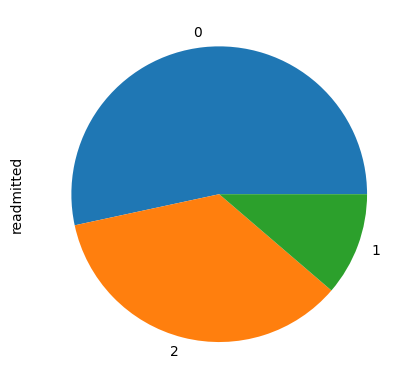

In [35]:
dataframe_label['readmitted'].value_counts().plot(kind='pie')

In [36]:
dataframe_label.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 98052 entries, 1 to 101765
Data columns (total 49 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   patient_nbr               98052 non-null  int64   
 1   race                      98052 non-null  category
 2   gender                    98052 non-null  category
 3   age                       98052 non-null  int64   
 4   weight                    98052 non-null  int32   
 5   admission_type_id         98052 non-null  category
 6   discharge_disposition_id  98052 non-null  category
 7   admission_source_id       98052 non-null  category
 8   time_in_hospital          98052 non-null  int64   
 9   payer_code                98052 non-null  category
 10  medical_specialty         98052 non-null  category
 11  num_lab_procedures        98052 non-null  int64   
 12  num_procedures            98052 non-null  int64   
 13  num_medications           98052 non-null  int

<AxesSubplot: ylabel='readmitted'>

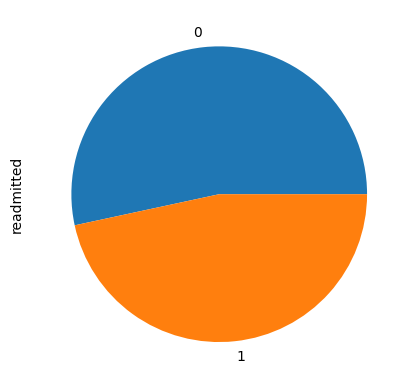

In [37]:
dataframe_label_binary=dataframe_label.copy(deep=True)
dataframe_onehot_binary=dataframe_onehot.copy(deep=True)
dataframe_onehot_plus_binary=dataframe_onehot_plus.copy(deep=True)

dataframe_label_binary['readmitted'].replace(to_replace=2,value=1,inplace=True)
dataframe_onehot_binary['readmitted'].replace(to_replace=2,value=1,inplace=True)
dataframe_onehot_plus_binary['readmitted'].replace(to_replace=2,value=1,inplace=True)

dataframe_label_binary['readmitted'].value_counts().plot(kind='pie')

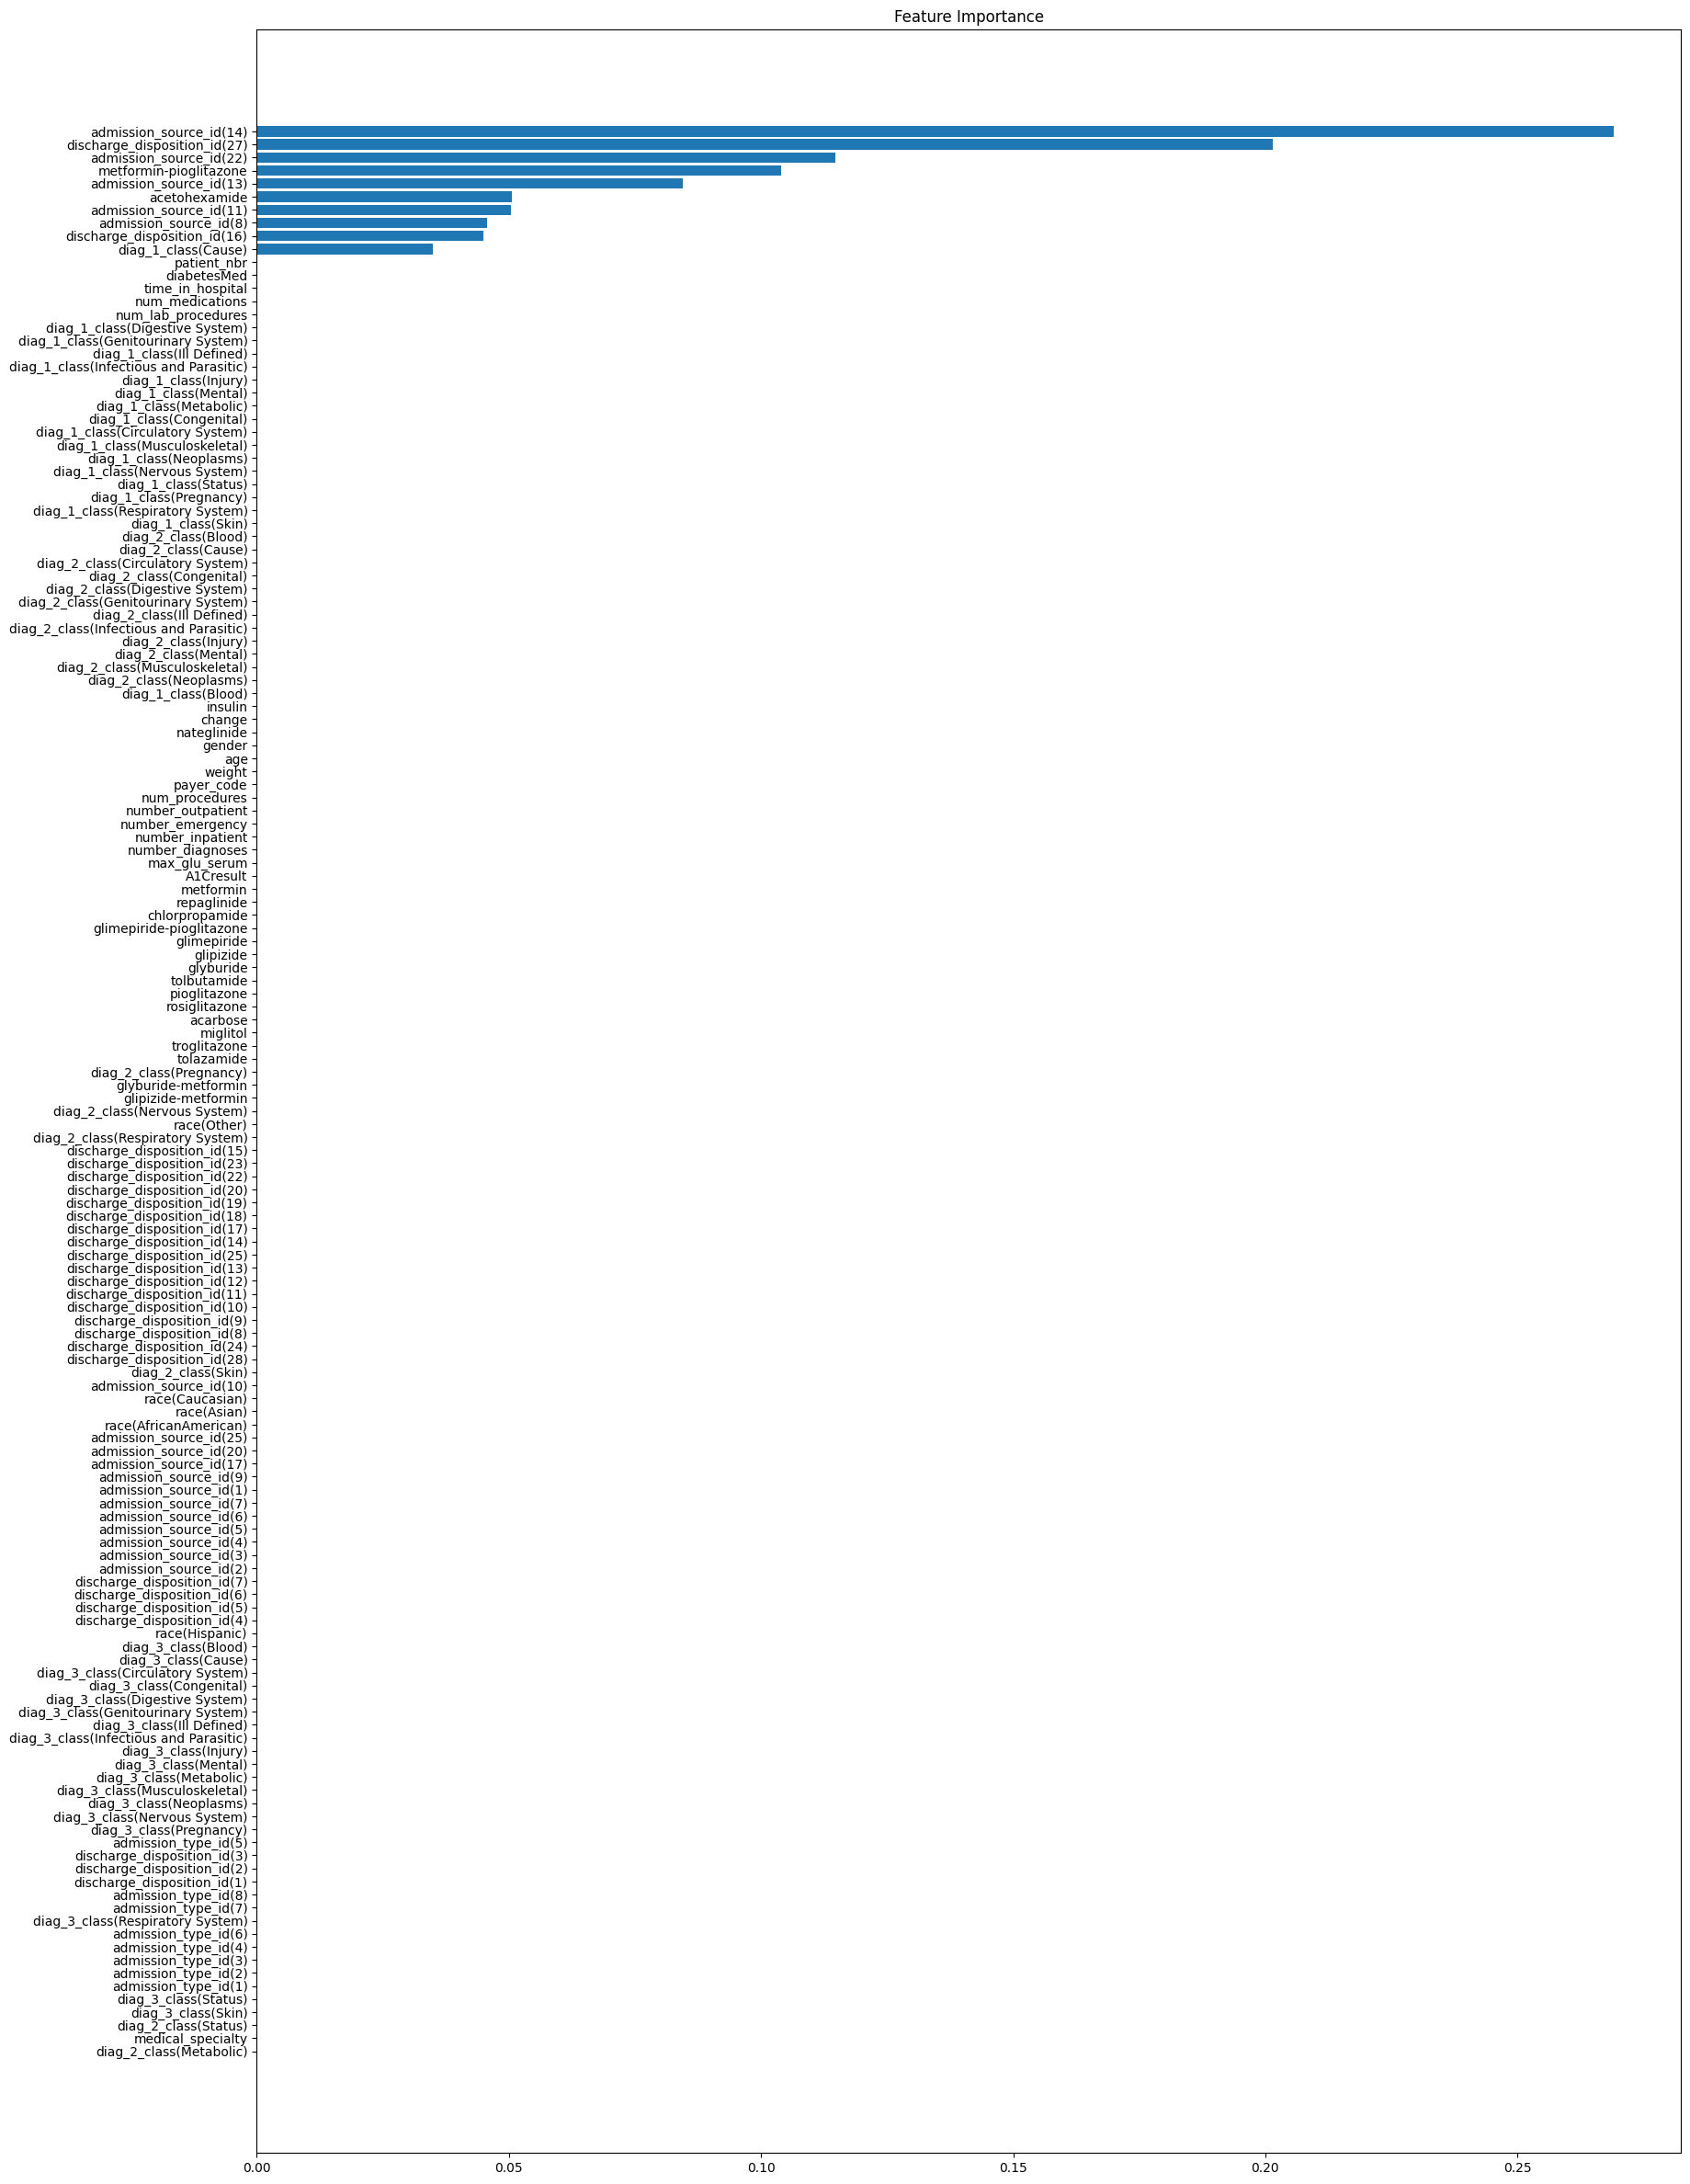

In [41]:
feature_importance(dataframe_onehot_plus_binary)

In [35]:
if run_long_tasks:
    scores, models=gridSearch(dataframe_label_binary, 'readmitted', search_space, metric='accuracy')
    sc = pd.DataFrame(scores,columns=['model','best_score','best_params'])
    print(sc)

Fitting 2 folds for each of 2 candidates, totalling 4 fits
7
Fitting 2 folds for each of 1 candidates, totalling 2 fits
3
                    model  best_score  \
0           random_forest    0.593022   
1  hist_gradient_boosting    0.611522   

                                         best_params  
0                               {'n_estimators': 20}  
1  {'l2_regularization': 1.5, 'learning_rate': 0....  


In [36]:
if run_long_tasks:
    scores, models=gridSearch(dataframe_onehot_binary, 'readmitted', search_space, metric='accuracy')
    sc = pd.DataFrame(scores,columns=['model','best_score','best_params'])
    print(sc)

Fitting 2 folds for each of 2 candidates, totalling 4 fits
9
Fitting 2 folds for each of 1 candidates, totalling 2 fits
5
                    model  best_score  \
0           random_forest    0.595062   
1  hist_gradient_boosting    0.611135   

                                         best_params  
0                               {'n_estimators': 20}  
1  {'l2_regularization': 1.5, 'learning_rate': 0....  


In [37]:
if run_long_tasks:
    scores, models=gridSearch(dataframe_onehot_plus_binary, 'readmitted', search_space, metric='accuracy')
    sc = pd.DataFrame(scores,columns=['model','best_score','best_params'])
    print(sc)

Fitting 2 folds for each of 2 candidates, totalling 4 fits
10
Fitting 2 folds for each of 1 candidates, totalling 2 fits
7
                    model  best_score  \
0           random_forest    0.595969   
1  hist_gradient_boosting    0.613256   

                                         best_params  
0                               {'n_estimators': 20}  
1  {'l2_regularization': 1.5, 'learning_rate': 0....  


In [38]:
def randomSearch(df, target, search_space, scorings=['accuracy','f1','f1_micro','f1_macro','roc_auc_ovr','roc_auc_ovo','roc_auc','precision'], metric='f1', folds=2):
    np.random.seed(0)
    scores = []
    models = []
    for model_name, mp in search_space.items():
        clf = RandomizedSearchCV(mp['model'], mp['params'], scoring=scorings, refit=metric, cv=folds, return_train_score=False, verbose=True,n_jobs=-1)
        best=clf.fit(df.drop(columns=[target]).values, df[target].values)
        models.append(best)
        scores.append({
            'model': model_name,
            'best_score': clf.best_score_,
            'best_params': clf.best_params_
        })
    return (scores,models)

In [39]:
search_space2 = {
    'random_forest': {
        'model': RandomForestClassifier(),
        'params': {
            'n_estimators': [int(x) for x in np.linspace(start = 200, stop = 2000, num = 3)],
            'max_features': ['auto', 'sqrt'],
            'max_depth' : list([int(x) for x in np.linspace(10, 110, num = 3)]),
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'bootstrap': [True, False]
        }
    },
    'logistic_regression': {
        'model': LogisticRegression(solver='liblinear', multi_class='auto'),
        'params': {
            'penalty': ['l1', 'l2'],
            'C': np.logspace(-4, 4, 20),
            'solver' : ['liblinear']
        }
    },
    'hist_gradient_boosting': {
        'model': HistGradientBoostingClassifier(),
        'params': {
            'max_iter': [100,1000,1200],  #1500
            'learning_rate': [0.4],
            'max_depth': [25, 50, 75], #75
            'scoring': ['f1_micro'],
            'l2_regularization': [1.5]
        }
    },
    'SGD': {
        'model': SGDClassifier(),
        'params': {
            'max_iter': [5, 10, 100, 1000],
            "loss" : ["hinge", "log", "squared_hinge", "modified_huber"],
            "alpha" : [0.0001, 0.001, 0.01, 0.1],
            "penalty" : ["l2", "l1", "none"],
        }
    }
}

In [40]:
s=set(non_categorical_cols)
search_space2['hist_gradient_boosting']['params']['categorical_features']=[[x=='category' for x in dataframe_label_binary.drop(columns=['readmitted']).dtypes],[]]

In [41]:
if run_long_tasks and False:
    scores, models=gridSearch(dataframe_label_binary, 'readmitted', search_space2, metric='accuracy')
    sc = pd.DataFrame(scores,columns=['model','best_score','best_params'])
    print(sc)

In [42]:
def standardize(df,to_scale):
    scaler = MinMaxScaler()
    to_transform=df.drop([x for x in df.columns if x not in to_scale], axis=1)
    scaled = pd.DataFrame(scaler.fit_transform(to_transform))
    new_df = df.copy(deep=True)
    for index,col in enumerate(to_scale):
        new_df[col]=scaled[index]
    new_df.dropna(inplace=True)
    return new_df

def normalize(df, to_scale):#	It is really affected by outliers.
    scaler = StandardScaler()
    to_transform=df.drop([x for x in df.columns if x not in to_scale], axis=1)
    scaled = pd.DataFrame(scaler.fit_transform(to_transform))
    new_df = df.copy(deep=True)
    for index,col in enumerate(to_scale):
        new_df[col]=scaled[index]
    new_df.dropna(inplace=True)
    return new_df

In [43]:
dataframe_label_binary_standard=standardize(dataframe_label_binary,[x for x in non_categorical_cols if x not in ['patient_nbr','diag_1','diag_2','diag_3']])

In [44]:
if run_long_tasks:
    scores, models=gridSearch(dataframe_label_binary_standard, 'readmitted', search_space, metric='accuracy')
    sc = pd.DataFrame(scores,columns=['model','best_score','best_params'])
    print(sc)

Fitting 2 folds for each of 2 candidates, totalling 4 fits
7
Fitting 2 folds for each of 1 candidates, totalling 2 fits
3
                    model  best_score  \
0           random_forest    0.554564   
1  hist_gradient_boosting    0.571627   

                                         best_params  
0                               {'n_estimators': 20}  
1  {'l2_regularization': 1.5, 'learning_rate': 0....  


In [45]:
dataframe_label_binary_normal=normalize(dataframe_label_binary,[x for x in non_categorical_cols if x not in ['patient_nbr','diag_1','diag_2','diag_3']])

In [46]:
if run_long_tasks:
    scores, models=gridSearch(dataframe_label_binary_normal, 'readmitted', search_space, metric='accuracy')
    sc = pd.DataFrame(scores,columns=['model','best_score','best_params'])
    print(sc)

Fitting 2 folds for each of 2 candidates, totalling 4 fits
7
Fitting 2 folds for each of 1 candidates, totalling 2 fits
3
                    model  best_score  \
0           random_forest    0.555443   
1  hist_gradient_boosting    0.571743   

                                         best_params  
0                               {'n_estimators': 20}  
1  {'l2_regularization': 1.5, 'learning_rate': 0....  


Outliers detection:

In [47]:
from sklearn.covariance import EllipticEnvelope

In [48]:
def remove_outliers(df, cols, factor=0.1):
    standard=standardize(df, cols)
    outlier_detector = EllipticEnvelope(contamination=factor)
    outlier_detector.fit(standard)
    outlier_array= outlier_detector.predict(standard)
    to_drop=[]
    for index,x in enumerate(outlier_array):
        if x==-1:
            to_drop.append(index)

    standard.drop(standard.index[to_drop],inplace=True)
    return standardize(standard, cols)

<AxesSubplot: >

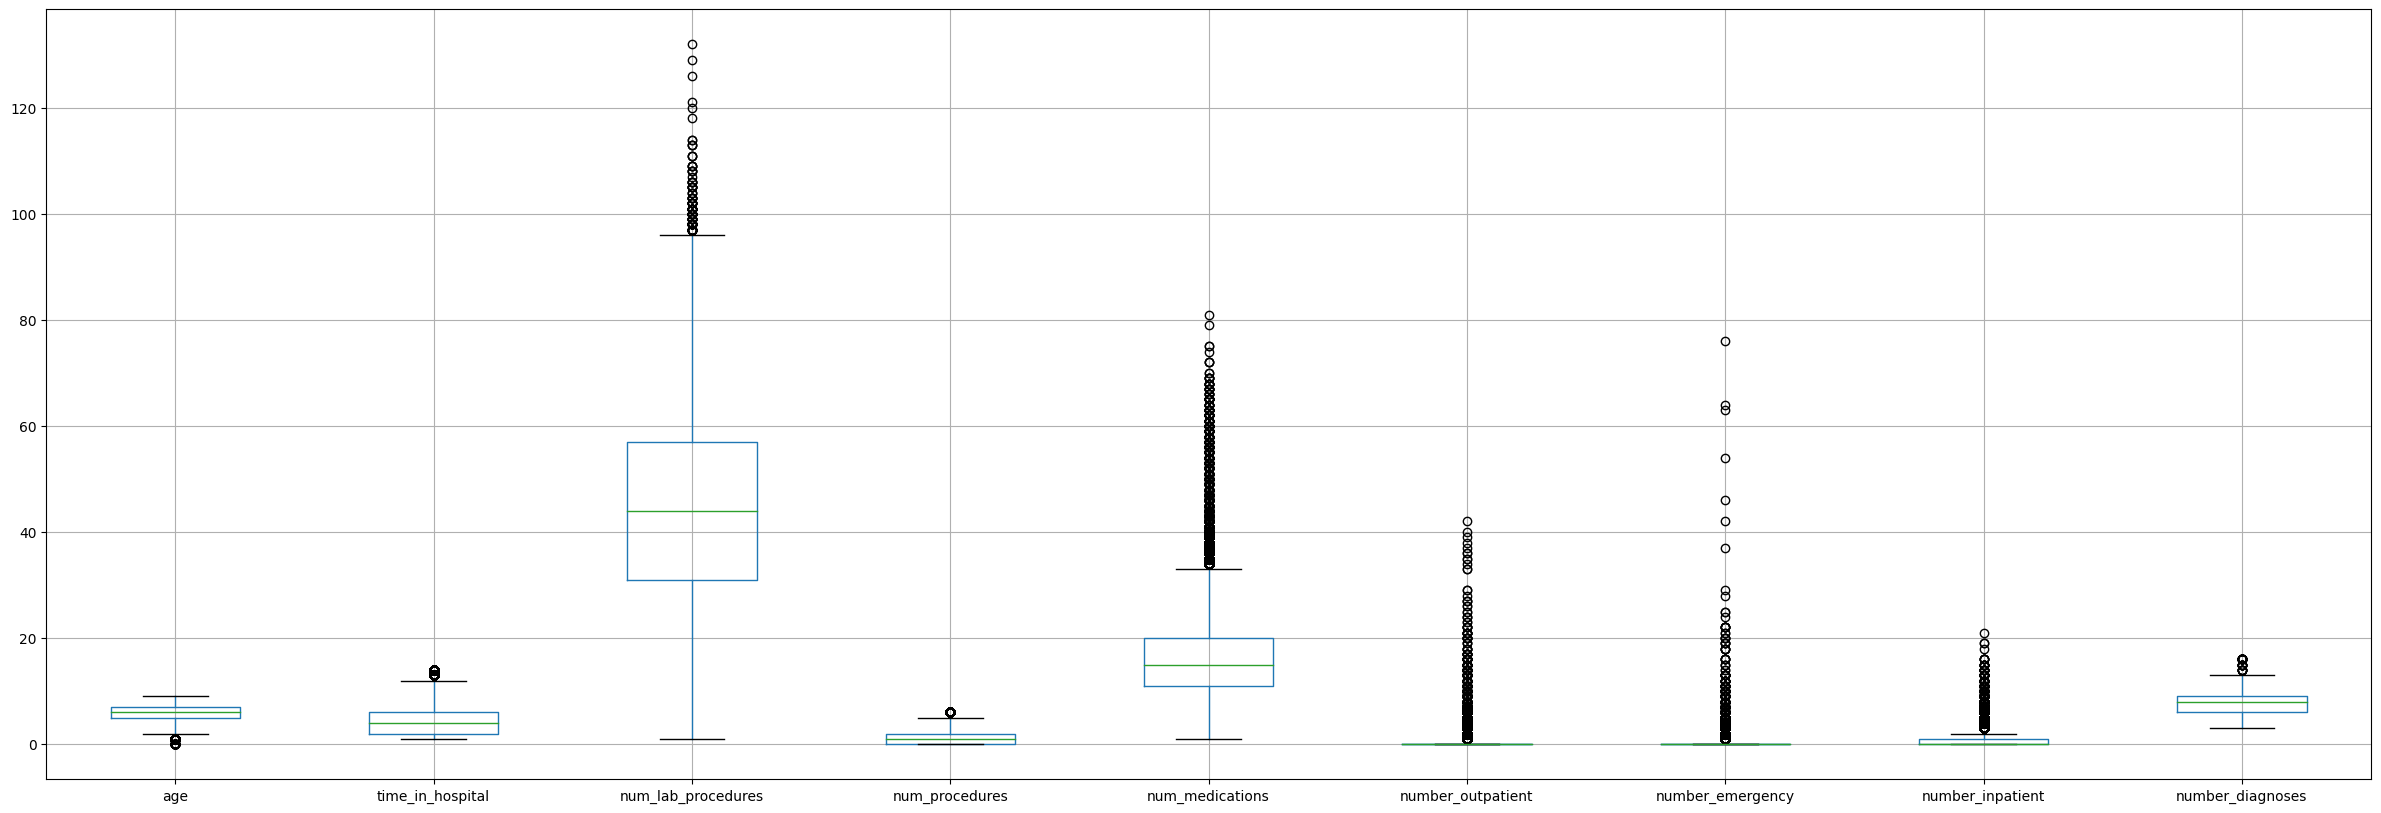

In [49]:
to_plot=[x for x in non_categorical_cols if x not in ['patient_nbr','diag_1','diag_2','diag_3','weight','']]
dataframe_label_binary.boxplot(column=to_plot, figsize=(30,10))

<AxesSubplot: >

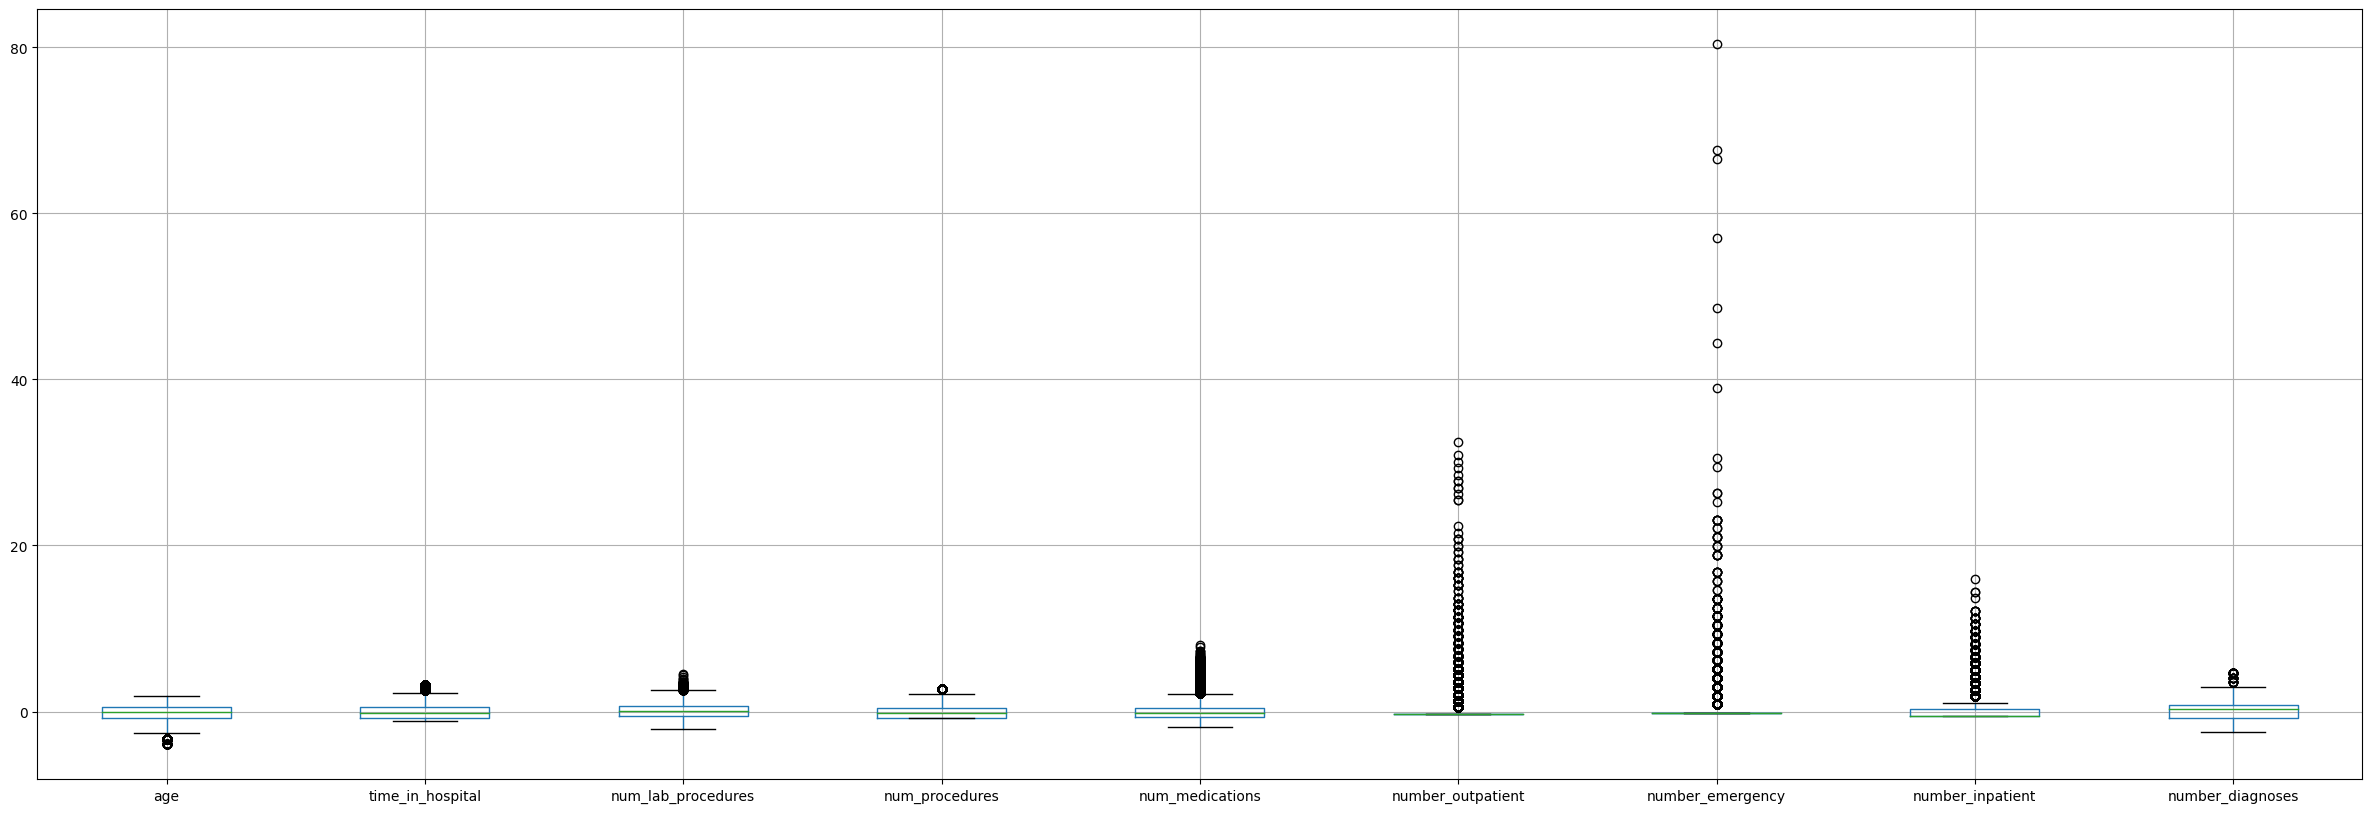

In [50]:
dataframe_label_binary_normal.boxplot(column=to_plot, figsize=(30,10))

c:\Users\PC\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\covariance\_robust_covariance.py:738: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn(


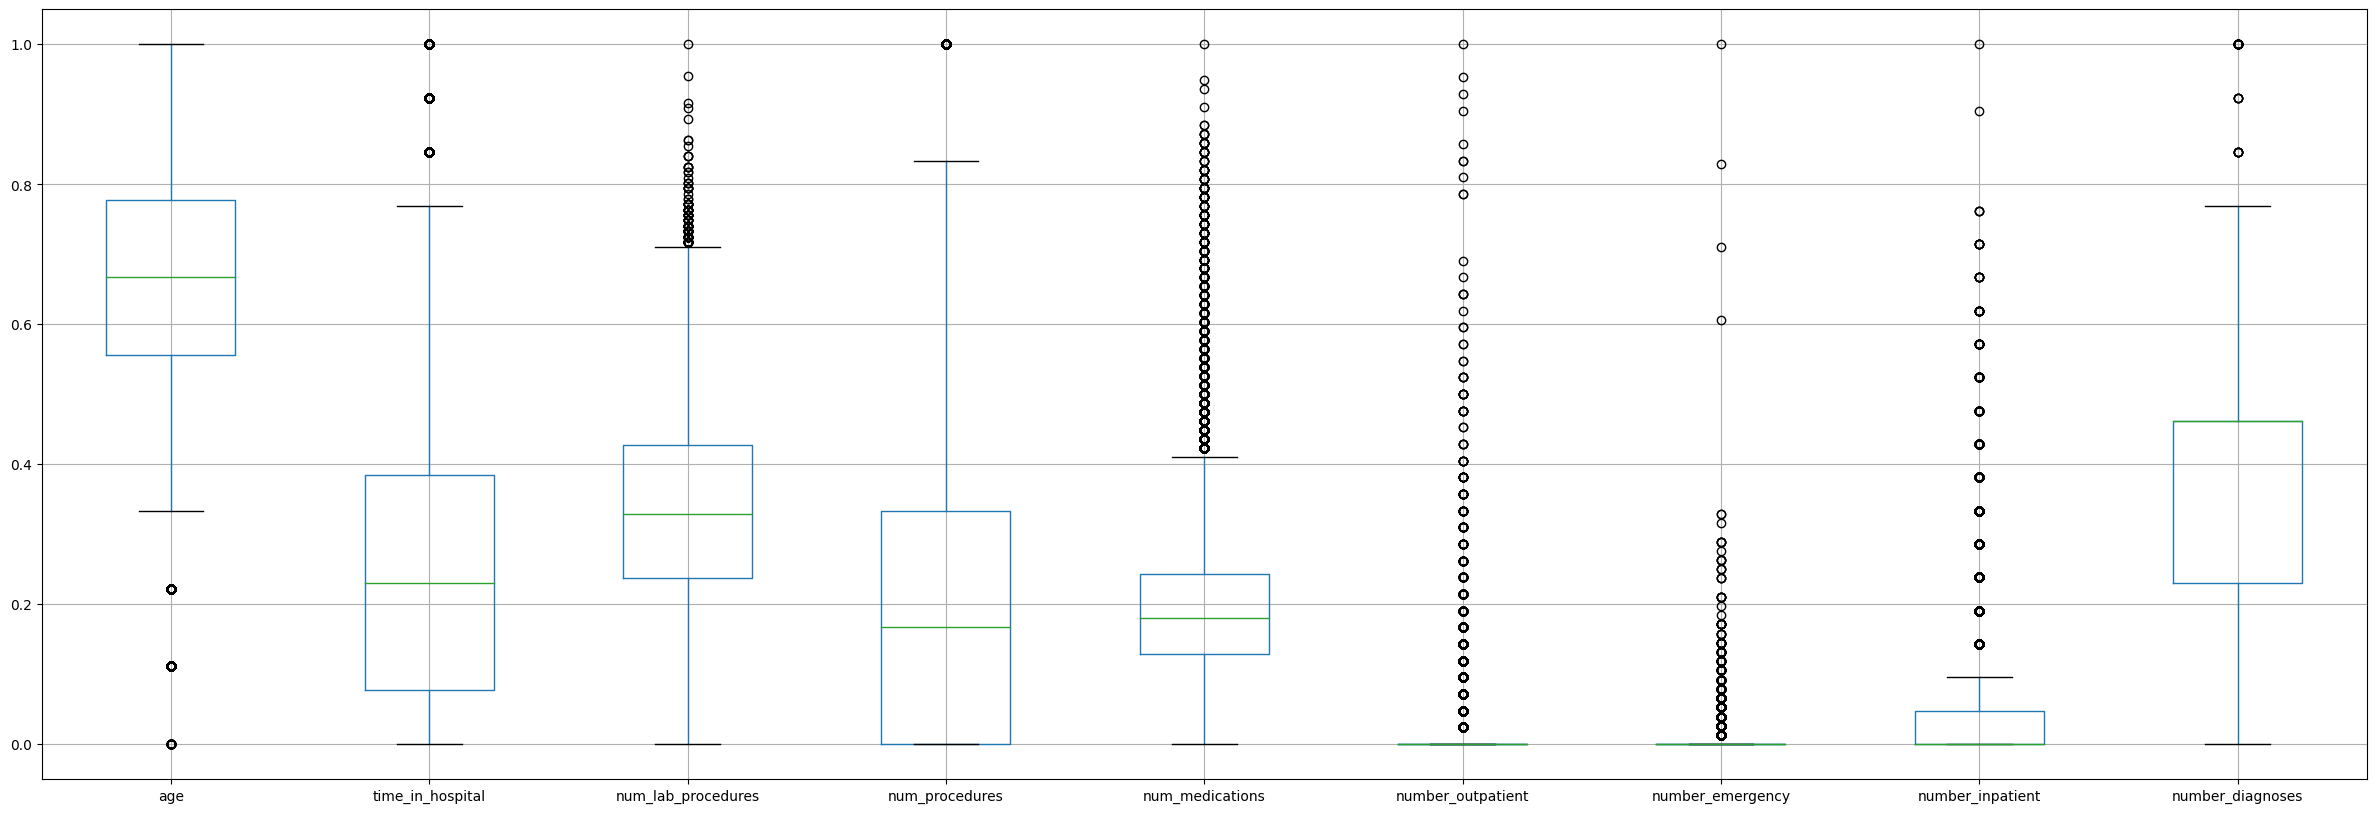

In [51]:
if run_long_tasks:
    df_no_outliers=remove_outliers(dataframe_label_binary,to_plot)
    df_no_outliers.boxplot(column=to_plot, figsize=(30,10))

In [52]:
if run_long_tasks:  
    df_no_outliers.shape

In [53]:
if run_long_tasks:
    #s=set(non_categorical_cols)
    #search_space2['hist_gradient_boosting']['params']['categorical_features']=[[x=='category' for x in df_no_outliers.drop(columns=['readmitted']).dtypes],[]]
    scores, models=gridSearch(df_no_outliers, 'readmitted', search_space, metric='accuracy')
    sc = pd.DataFrame(scores,columns=['model','best_score','best_params'])
    print(sc)


Fitting 2 folds for each of 2 candidates, totalling 4 fits
5
Fitting 2 folds for each of 1 candidates, totalling 2 fits
2
                    model  best_score  \
0           random_forest    0.554546   
1  hist_gradient_boosting    0.562215   

                                         best_params  
0                               {'n_estimators': 20}  
1  {'l2_regularization': 1.5, 'learning_rate': 0....  


In [54]:
if run_long_tasks and False:
    s=set(non_categorical_cols)
    search_space2['hist_gradient_boosting']['params']['categorical_features']=[[x=='category' for x in dataframe_onehot_binary.drop(columns=['readmitted']).dtypes],[]]
    scores, models=randomSearch(dataframe_onehot_binary, 'readmitted', search_space2, metric='accuracy')
    sc = pd.DataFrame(scores,columns=['model','best_score','best_params'])
    print(sc)

In [57]:
if run_long_tasks and False:
    from sklearn.metrics import RocCurveDisplay
    fig, ax = plt.subplots()
    model_displays = {}
    for ind,model in enumerate(models):
        model_displays[scores[ind]['model']] = RocCurveDisplay.from_estimator(
            model.best_estimator_, dataframe_onehot_binary.drop('readmitted',axis=1).values, dataframe_onehot_binary['readmitted'], ax=ax, name=scores[ind]['model']
        )
    _ = ax.set_title("ROC curve")

In [58]:
# forest=models[0].best_estimator_
# importances = forest.feature_importances_
# std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
# forest_importances = pd.Series(importances, index=dataframe_label_binary_standard.drop('readmitted', axis=1).columns)

# fig, ax = plt.subplots()
# forest_importances.plot.bar(yerr=std, ax=ax)
# ax.set_title("Feature importances using MDI")
# ax.set_ylabel("Mean decrease in impurity")
# fig.tight_layout()

In [59]:
dataframe_onehot_binary.head()

,patient_nbr,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,diag_1_class(Blood),diag_1_class(Cause),diag_1_class(Circulatory System),diag_1_class(Congenital),diag_1_class(Digestive System),diag_1_class(Genitourinary System),diag_1_class(Ill Defined),diag_1_class(Infectious and Parasitic),diag_1_class(Injury),diag_1_class(Mental),diag_1_class(Metabolic),diag_1_class(Musculoskeletal),diag_1_class(Neoplasms),diag_1_class(Nervous System),diag_1_class(Pregnancy),diag_1_class(Respiratory System),diag_1_class(Skin),diag_1_class(Status),diag_2_class(Blood),diag_2_class(Cause),diag_2_class(Circulatory System),diag_2_class(Congenital),diag_2_class(Digestive System),diag_2_class(Genitourinary System),diag_2_class(Ill Defined),diag_2_class(Infectious and Parasitic),diag_2_class(Injury),diag_2_class(Mental),diag_2_class(Metabolic),diag_2_class(Musculoskeletal),diag_2_class(Neoplasms),diag_2_class(Nervous System),diag_2_class(Pregnancy),diag_2_class(Respiratory System),diag_2_class(Skin),diag_2_class(Status),diag_3_class(Blood),diag_3_class(Cause),diag_3_class(Circulatory System),diag_3_class(Congenital),diag_3_class(Digestive System),diag_3_class(Genitourinary System),diag_3_class(Ill Defined),diag_3_class(Infectious and Parasitic),diag_3_class(Injury),diag_3_class(Mental),diag_3_class(Metabolic),diag_3_class(Musculoskeletal),diag_3_class(Neoplasms),diag_3_class(Nervous System),diag_3_class(Pregnancy),diag_3_class(Respiratory System),diag_3_class(Skin),diag_3_class(Status),race(AfricanAmerican),race(Asian),race(Caucasian),race(Hispanic),race(Other)
0,55629189,0,1,3,1,1,7,3,15,71,59,0,18,0,0,0,143,77,121,9,0,0,1,1,1,1,1,0,1,1,0,1,1,1,1,0,0,3,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
1,86047875,0,2,3,1,1,7,2,15,71,11,5,13,2,0,1,454,76,763,6,0,0,1,1,1,1,1,0,2,1,0,1,1,1,1,0,0,1,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0
2,82442376,1,3,3,1,1,7,2,15,71,44,1,16,0,0,0,553,95,248,7,0,0,1,1,1,1,1,0,1,1,0,1,1,1,1,0,0,3,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,42519267,1,4,3,1,1,7,1,15,71,51,0,8,0,0,0,54,23,86,5,0,0,1,1,1,1,1,0,2,1,0,1,1,1,1,0,0,2,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
4,82637451,1,5,3,2,1,2,3,15,71,31,6,16,0,0,0,263,244,86,9,0,0,1,1,1,1,1,0,1,1,0,1,1,1,1,0,0,2,1,0,0,0,1,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0


In [60]:
sig=['readmitted','race','diag_1','discharge_disposition_id','medical_specialty','age','time_in_hospital','A1Cresult']
sig+=([x for x in dataframe_onehot_binary.columns if 'diag_1_' in x])
df_test=dataframe_onehot_binary.drop([x for x in dataframe_onehot_binary if x not in sig], axis=1)
search_space['hist_gradient_boosting']['params']['categorical_features']=[[]]

if run_long_tasks:
    scores, models=randomSearch(df_test, 'readmitted', search_space, metric='accuracy')
    sc = pd.DataFrame(scores,columns=['model','best_score','best_params'])
    print(sc)

c:\Users\PC\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_search.py:306: UserWarning: The total space of parameters 2 is smaller than n_iter=10. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 2 folds for each of 2 candidates, totalling 4 fits


c:\Users\PC\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_search.py:306: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 2 folds for each of 1 candidates, totalling 2 fits
                    model  best_score  \
0           random_forest    0.546139   
1  hist_gradient_boosting    0.564915   

                                         best_params  
0                               {'n_estimators': 20}  
1  {'max_iter': 100, 'max_depth': 50, 'learning_r...  


In [61]:
dataframe['readmitted'].value_counts()

0    52337
2    34649
1    11066
Name: readmitted, dtype: int64

Modifikacija dataset-a

In [62]:
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


def roc(scores, models, df):
    fig, ax = plt.subplots()
    model_displays = {}
    for ind,model in enumerate(models):
        model_displays[scores[ind]['model']] = RocCurveDisplay.from_estimator(
            model.best_estimator_, df.drop('readmitted',axis=1).values, df['readmitted'], ax=ax, name=scores[ind]['model']
        )
    _ = ax.set_title("ROC curve")
    
def confusion(models,df):
    for ind,model in enumerate(models):
        predictions = model.best_estimator_.predict(df.drop('readmitted',axis=1))
        cm = confusion_matrix(df['readmitted'], predictions, labels=model.best_estimator_.classes_)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                    display_labels=model.best_estimator_.classes_)
        disp.plot()
        print(model.best_estimator_)
        plt.show()


0    86986
1    11066
Name: readmitted, dtype: int64

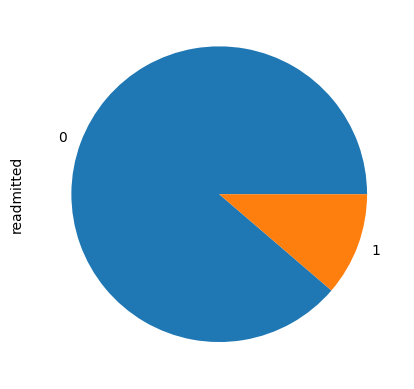

In [63]:
dataframe_label_binary2=dataframe_label.copy(deep=True)
dataframe_onehot_binary2=dataframe_onehot.copy(deep=True)
dataframe_onehot_plus_binary2=dataframe_onehot_plus.copy(deep=True)

dataframe_label_binary2['readmitted'].replace(to_replace=2,value=0,inplace=True)
dataframe_onehot_binary2['readmitted'].replace(to_replace=2,value=0,inplace=True)
dataframe_onehot_plus_binary2['readmitted'].replace(to_replace=2,value=0,inplace=True)

dataframe_label_binary2['readmitted'].value_counts().plot(kind='pie')
dataframe_label_binary2['readmitted'].value_counts()

Osnovni dataset

In [64]:
if run_long_tasks or final_df:
    scores, models=randomSearch(dataframe_onehot_binary2, 'readmitted', search_space, metric='f1')
    sc = pd.DataFrame(scores,columns=['model','best_score','best_params'])
    print(sc)

c:\Users\PC\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_search.py:306: UserWarning: The total space of parameters 2 is smaller than n_iter=10. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 2 folds for each of 2 candidates, totalling 4 fits


c:\Users\PC\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_search.py:306: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 2 folds for each of 1 candidates, totalling 2 fits
                    model  best_score  \
0           random_forest    0.021211   
1  hist_gradient_boosting    0.060814   

                                         best_params  
0                               {'n_estimators': 10}  
1  {'max_iter': 100, 'max_depth': 50, 'learning_r...  


In [65]:
from imblearn.over_sampling import RandomOverSampler,SMOTE
from imblearn.under_sampling import RandomUnderSampler,ClusterCentroids, TomekLinks

In [66]:
def get_balanced_dataframe_oversample(df,algorithm=SMOTE,ratio=0.9,target="readmitted",):
    new_df=df.copy(deep=True)

    #RandomOverSampler,SMOTE
    oversample = algorithm(sampling_strategy=ratio)

    X_resampled, y_resampled = oversample.fit_resample(new_df.drop(columns=[target,]), new_df[target])

    return  pd.concat([X_resampled, y_resampled], axis=1)



Oversample

c:\Users\PC\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_search.py:306: UserWarning: The total space of parameters 2 is smaller than n_iter=10. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 2 folds for each of 2 candidates, totalling 4 fits


c:\Users\PC\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_search.py:306: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 2 folds for each of 1 candidates, totalling 2 fits


,model,best_score,best_params
0,random_forest,0.799207,{'n_estimators': 10}
1,hist_gradient_boosting,0.801200,"{'max_iter': 100, 'max_depth': 50, 'learning_r..."


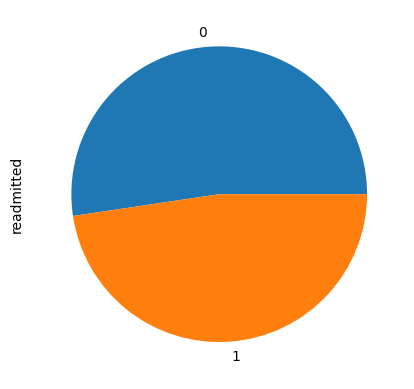

In [103]:
if run_long_tasks or final_df:
    new=get_balanced_dataframe_oversample(dataframe_onehot_binary2,algorithm=SMOTE,ratio=0.91)
    new['readmitted'].value_counts().plot(kind='pie')

    scores, models=randomSearch(new, 'readmitted', search_space, metric='f1')
    sc = pd.DataFrame(scores,columns=['model','best_score','best_params'])
sc

In [104]:
def get_balanced_dataframe_undersample(df,algorithm=RandomUnderSampler,ratio=0.91,target="readmitted"):
    new_df=df.copy(deep=True)

    #ClusterCentroids,RandomUnderSampler
    undersample = algorithm(random_state=0,sampling_strategy=ratio)

    X_resampled, y_resampled = undersample.fit_resample(new_df.drop(columns=[target,]), new_df[target])

    return  pd.concat([X_resampled, y_resampled], axis=1)


Undersample

In [106]:
if run_long_tasks or final_df:
    new=get_balanced_dataframe_undersample(dataframe_onehot_binary2,algorithm=RandomUnderSampler,ratio=0.90)
    print(new["readmitted"].value_counts())

    scores, models=randomSearch(new, 'readmitted', search_space, metric='f1', folds=5)
    sc = pd.DataFrame(scores,columns=['model','best_score','best_params'])
sc

0    86985
1    78287
Name: readmitted, dtype: int64


c:\Users\PC\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_search.py:306: UserWarning: The total space of parameters 2 is smaller than n_iter=10. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 2 candidates, totalling 10 fits


c:\Users\PC\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_search.py:306: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


,model,best_score,best_params
0,random_forest,0.883641,{'n_estimators': 20}
1,hist_gradient_boosting,0.883653,"{'max_iter': 100, 'max_depth': 50, 'learning_r..."


In [70]:
dataframe_label_binary2=get_balanced_dataframe_oversample(dataframe_label_binary2,algorithm=SMOTE,ratio=0.9)
dataframe_onehot_binary2=get_balanced_dataframe_oversample(dataframe_onehot_binary2,algorithm=SMOTE,ratio=0.9)
dataframe_onehot_plus_binary2=get_balanced_dataframe_oversample(dataframe_onehot_plus_binary2,algorithm=SMOTE,ratio=0.9)

In [71]:
search_space3 = {
    'random_forest': { # ~12sec
        'model': RandomForestClassifier(),
        'params': {
            'n_estimators': [10, 20]  # [1,5,10]
        }
    },
    # 'logistic_regression': { # ~4min (0.3)
    #     'model': LogisticRegression(solver='saga'),
    #     'params': {
    #         'penalty': ['l1',],
    #         'C': [1, 5],
    #         'max_iter': [1000,] # ne konvergira na <1000
    #     }
    # },
    # 'knn': { # ~6min (0.5)
    #     'model': KNeighborsClassifier(algorithm='auto'),
    #     'params': {
    #         'n_neighbors': [5,],
    #         'leaf_size': [30,],
    #         'p': [2,],
    #         'weights': ['uniform',]
    #     }
    # },
    'decision_tree': { # ~7sec
        'model': DecisionTreeClassifier(),
        'params': {
            'criterion': ['gini'],
            'max_depth': [50]
        }
    },
    # 'naive_bayes': { # error - negativne vrednosti?????????????
    #     'model': MultinomialNB(),
    #     'params': {
    #     }
    # },
    # 'gradient_boosting': { # not useful for large datasets.
    #     'model': GradientBoostingClassifier(),
    #     'params': {
    #         'learning_rate': [0.4],
    #         'subsample': [0.5,],
    #         'n_estimators': [100],
    #         'max_depth': [50]
    #     }
    # },
    'hist_gradient_boosting': { # ~15 sec
        'model': HistGradientBoostingClassifier(),
        'params': {
            'max_iter': [100],
            'learning_rate': [0.4],
            'max_depth': [50],
            'l2_regularization': [1.5],
        }
    },
}

Label encoded oversample

In [72]:
if run_long_tasks or final_df:
    scores, models=randomSearch(dataframe_label_binary2, 'readmitted', search_space3, metric='f1', folds=2)
    sc = pd.DataFrame(scores,columns=['model','best_score','best_params'])
    print(sc)

c:\Users\PC\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_search.py:306: UserWarning: The total space of parameters 2 is smaller than n_iter=10. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 2 folds for each of 2 candidates, totalling 4 fits


c:\Users\PC\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_search.py:306: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 2 folds for each of 1 candidates, totalling 2 fits


c:\Users\PC\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_search.py:306: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 2 folds for each of 1 candidates, totalling 2 fits
                    model  best_score  \
0           random_forest    0.739380   
1           decision_tree    0.707569   
2  hist_gradient_boosting    0.769405   

                                         best_params  
0                               {'n_estimators': 20}  
1             {'max_depth': 50, 'criterion': 'gini'}  
2  {'max_iter': 100, 'max_depth': 50, 'learning_r...  


One-hot oversample

In [73]:
if run_long_tasks or final_df:
    scores, models=randomSearch(dataframe_onehot_binary2, 'readmitted', search_space3, metric='f1', folds=2)
    sc = pd.DataFrame(scores,columns=['model','best_score','best_params'])
    print(sc)

c:\Users\PC\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_search.py:306: UserWarning: The total space of parameters 2 is smaller than n_iter=10. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 2 folds for each of 2 candidates, totalling 4 fits


c:\Users\PC\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_search.py:306: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 2 folds for each of 1 candidates, totalling 2 fits


c:\Users\PC\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_search.py:306: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 2 folds for each of 1 candidates, totalling 2 fits
                    model  best_score  \
0           random_forest    0.798916   
1           decision_tree    0.739990   
2  hist_gradient_boosting    0.805200   

                                         best_params  
0                               {'n_estimators': 10}  
1             {'max_depth': 50, 'criterion': 'gini'}  
2  {'max_iter': 100, 'max_depth': 50, 'learning_r...  


One-hot plus oversample

In [107]:
if run_long_tasks or final_df:
    scores, models=randomSearch(dataframe_onehot_plus_binary2, 'readmitted', search_space3, metric='f1', folds=2)
    sc = pd.DataFrame(scores,columns=['model','best_score','best_params'])
sc

c:\Users\PC\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_search.py:306: UserWarning: The total space of parameters 2 is smaller than n_iter=10. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 2 folds for each of 2 candidates, totalling 4 fits


c:\Users\PC\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_search.py:306: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 2 folds for each of 1 candidates, totalling 2 fits


c:\Users\PC\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_search.py:306: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 2 folds for each of 1 candidates, totalling 2 fits


,model,best_score,best_params
0,random_forest,0.802281,{'n_estimators': 10}
1,decision_tree,0.744190,"{'max_depth': 50, 'criterion': 'gini'}"
2,hist_gradient_boosting,0.800627,"{'max_iter': 100, 'max_depth': 50, 'learning_r..."


Normalized

In [75]:
dfohpb2_normal=normalize(dataframe_onehot_plus_binary2,[x for x in non_categorical_cols if x not in ['patient_nbr','diag_1','diag_2','diag_3']])
if run_long_tasks or final_df:
    scores, models=randomSearch(dfohpb2_normal, 'readmitted', search_space3, metric='f1', folds=2)
    sc = pd.DataFrame(scores,columns=['model','best_score','best_params'])
    print(sc)

c:\Users\PC\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_search.py:306: UserWarning: The total space of parameters 2 is smaller than n_iter=10. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 2 folds for each of 2 candidates, totalling 4 fits


c:\Users\PC\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_search.py:306: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 2 folds for each of 1 candidates, totalling 2 fits


c:\Users\PC\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_search.py:306: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 2 folds for each of 1 candidates, totalling 2 fits
                    model  best_score  \
0           random_forest    0.800153   
1           decision_tree    0.745540   
2  hist_gradient_boosting    0.801296   

                                         best_params  
0                               {'n_estimators': 20}  
1             {'max_depth': 50, 'criterion': 'gini'}  
2  {'max_iter': 100, 'max_depth': 50, 'learning_r...  


Standardized

In [108]:
dfohpb2_standard=standardize(dataframe_onehot_plus_binary2,[x for x in non_categorical_cols if x not in ['patient_nbr','diag_1','diag_2','diag_3']])
if run_long_tasks or final_df:
    scores, models=randomSearch(dfohpb2_standard, 'readmitted', search_space3, metric='f1', folds=2)
    sc = pd.DataFrame(scores,columns=['model','best_score','best_params'])
sc

c:\Users\PC\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_search.py:306: UserWarning: The total space of parameters 2 is smaller than n_iter=10. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 2 folds for each of 2 candidates, totalling 4 fits


c:\Users\PC\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_search.py:306: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 2 folds for each of 1 candidates, totalling 2 fits


c:\Users\PC\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_search.py:306: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 2 folds for each of 1 candidates, totalling 2 fits


,model,best_score,best_params
0,random_forest,0.799582,{'n_estimators': 20}
1,decision_tree,0.745215,"{'max_depth': 50, 'criterion': 'gini'}"
2,hist_gradient_boosting,0.804809,"{'max_iter': 100, 'max_depth': 50, 'learning_r..."


Outlier removal

In [77]:
if run_long_tasks:
    dfohpb2_out=remove_outliers(dataframe_onehot_plus_binary2,[x for x in non_categorical_cols if x not in ['patient_nbr','diag_1','diag_2','diag_3','weight']])
    #~5min
    scores, models=randomSearch(dfohpb2_out, 'readmitted', search_space3, metric='f1', folds=2)
    sc = pd.DataFrame(scores,columns=['model','best_score','best_params'])
    print(sc)

c:\Users\PC\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_search.py:306: UserWarning: The total space of parameters 2 is smaller than n_iter=10. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 2 folds for each of 2 candidates, totalling 4 fits


c:\Users\PC\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_search.py:306: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 2 folds for each of 1 candidates, totalling 2 fits


c:\Users\PC\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_search.py:306: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 2 folds for each of 1 candidates, totalling 2 fits
                    model  best_score  \
0           random_forest    0.756456   
1           decision_tree    0.712288   
2  hist_gradient_boosting    0.773611   

                                         best_params  
0                               {'n_estimators': 20}  
1             {'max_depth': 50, 'criterion': 'gini'}  
2  {'max_iter': 100, 'max_depth': 50, 'learning_r...  


Standadrized + normalized

In [78]:
cols=[x for x in non_categorical_cols if x not in ['patient_nbr','diag_1','diag_2','diag_3']]
dfohpb2_std_n=normalize(standardize(dataframe_onehot_plus_binary2,cols),cols)
if run_long_tasks or final_df:
    scores, models=randomSearch(dfohpb2_std_n, 'readmitted', search_space3, metric='f1', folds=2)
    sc = pd.DataFrame(scores,columns=['model','best_score','best_params'])
    print(sc)

c:\Users\PC\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_search.py:306: UserWarning: The total space of parameters 2 is smaller than n_iter=10. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 2 folds for each of 2 candidates, totalling 4 fits


c:\Users\PC\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_search.py:306: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 2 folds for each of 1 candidates, totalling 2 fits


c:\Users\PC\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_search.py:306: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 2 folds for each of 1 candidates, totalling 2 fits
                    model  best_score  \
0           random_forest    0.793942   
1           decision_tree    0.745650   
2  hist_gradient_boosting    0.805592   

                                         best_params  
0                               {'n_estimators': 10}  
1             {'max_depth': 50, 'criterion': 'gini'}  
2  {'max_iter': 100, 'max_depth': 50, 'learning_r...  


Boosting

In [79]:
from sklearn.ensemble import VotingClassifier
if run_long_tasks or final_df:
    clf = VotingClassifier(estimators=[
        ('rf',RandomForestClassifier(n_estimators=10)),
        ('dt',DecisionTreeClassifier(max_depth=50, criterion='gini')),
        ('hgb',HistGradientBoostingClassifier(max_iter=100,max_depth=50,learning_rate=0.4,l2_regularization=1.5))], voting='hard')

    grid = GridSearchCV(clf,{},cv=3,scoring='f1')
    grid.fit(dfohpb2_std_n.drop(columns=['readmitted']).values, dfohpb2_std_n['readmitted'].values)
    print(grid.best_score_)

0.8511875932043855


In [80]:
#Principal Component Analysis
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

def principalComponentAnalysis(df,target="readmitted"):
    new_df=df.copy(deep=True)

    y = new_df[target]
    X = new_df.drop(columns=[target])
    pca = PCA()
    X_transformed = pca.fit_transform(X)
    newDF=pd.DataFrame(X_transformed)
    newDF.insert(newDF.shape[1],target,y)
    return newDF

df_pca=principalComponentAnalysis(dfohpb2_std_n)



PCA

In [81]:
if run_long_tasks or final_df:
    scores, models=randomSearch(df_pca, 'readmitted', search_space3, metric='f1')
    sc = pd.DataFrame(scores,columns=['model','best_score','best_params'])
    print(sc)

c:\Users\PC\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_search.py:306: UserWarning: The total space of parameters 2 is smaller than n_iter=10. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 2 folds for each of 2 candidates, totalling 4 fits


c:\Users\PC\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_search.py:306: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 2 folds for each of 1 candidates, totalling 2 fits


c:\Users\PC\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_search.py:306: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 2 folds for each of 1 candidates, totalling 2 fits
                    model  best_score  \
0           random_forest    0.869182   
1           decision_tree    0.795086   
2  hist_gradient_boosting    0.830790   

                                         best_params  
0                               {'n_estimators': 20}  
1             {'max_depth': 50, 'criterion': 'gini'}  
2  {'max_iter': 100, 'max_depth': 50, 'learning_r...  


In [82]:
from sklearn.feature_selection import GenericUnivariateSelect, f_classif, mutual_info_classif

def genericUnivariate(df,ratio=0.9,target="readmitted"):
    new_df=df.copy(deep=True)

    y = new_df[target]
    X = new_df.drop(columns=[target])
    n_components=ceil(X.shape[1]*ratio)
    transformer = GenericUnivariateSelect(mutual_info_classif, mode='k_best', param=n_components)
    # transformer = GenericUnivariateSelect(mutual_info_classif, mode='k_best'
    X_transformed = transformer.fit_transform(X,y)
    newDF=pd.DataFrame(X_transformed)
    newDF.insert(newDF.shape[1],target,y)
    return newDF

df_uni=genericUnivariate(dfohpb2_std_n)


GenericUnivariateSelect

In [83]:
print(df_uni.shape)
if run_long_tasks or final_df:
    scores, models=randomSearch(df_uni, 'readmitted', search_space3, metric='f1')
    sc = pd.DataFrame(scores,columns=['model','best_score','best_params'])
    print(sc)

(165273, 137)
Fitting 2 folds for each of 2 candidates, totalling 4 fits


c:\Users\PC\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_search.py:306: UserWarning: The total space of parameters 2 is smaller than n_iter=10. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Users\PC\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_search.py:306: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 2 folds for each of 1 candidates, totalling 2 fits


c:\Users\PC\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_search.py:306: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 2 folds for each of 1 candidates, totalling 2 fits
                    model  best_score  \
0           random_forest    0.796365   
1           decision_tree    0.748123   
2  hist_gradient_boosting    0.806070   

                                         best_params  
0                               {'n_estimators': 10}  
1             {'max_depth': 50, 'criterion': 'gini'}  
2  {'max_iter': 100, 'max_depth': 50, 'learning_r...  


SelectKBest

In [99]:
selected = select_best_columns(dfohpb2_std_n, "readmitted", 0.8)
to_drop = set()
print("deleted columns:")

for col in dfohpb2_std_n.columns:
    if col not in selected:
        print(col)
        to_drop.add(col)
if run_long_tasks or final_df:
    scores, models=randomSearch(dfohpb2_std_n.drop(dfohpb2_std_n[list(to_drop)], axis=1), 'readmitted', search_space3, metric='f1')
    sc = pd.DataFrame(scores,columns=['model','best_score','best_params'])
sc

(165273, 119)
deleted columns:
diag_1
diag_2
diag_3
max_glu_serum
acetohexamide
troglitazone
glimepiride-pioglitazone
diag_1_class(Cause)
diag_1_class(Status)
diag_2_class(Congenital)
diag_3_class(Congenital)
diag_3_class(Infectious and Parasitic)
diag_3_class(Neoplasms)
diag_3_class(Nervous System)
admission_type_id(4)
admission_type_id(7)
admission_type_id(8)
discharge_disposition_id(5)
discharge_disposition_id(8)
discharge_disposition_id(10)
discharge_disposition_id(12)
discharge_disposition_id(16)
discharge_disposition_id(22)
discharge_disposition_id(27)
discharge_disposition_id(28)
admission_source_id(3)
admission_source_id(9)
admission_source_id(10)
admission_source_id(11)
admission_source_id(13)
admission_source_id(22)
race(Asian)


c:\Users\PC\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_search.py:306: UserWarning: The total space of parameters 2 is smaller than n_iter=10. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 2 folds for each of 2 candidates, totalling 4 fits


c:\Users\PC\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_search.py:306: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 2 folds for each of 1 candidates, totalling 2 fits


c:\Users\PC\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_search.py:306: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 2 folds for each of 1 candidates, totalling 2 fits


,model,best_score,best_params
0,random_forest,0.792107,{'n_estimators': 10}
1,decision_tree,0.746464,"{'max_depth': 50, 'criterion': 'gini'}"
2,hist_gradient_boosting,0.799465,"{'max_iter': 100, 'max_depth': 50, 'learning_r..."


Low variance

In [109]:
selected_columns = remove_low_variance_columns(
    dfohpb2_std_n, "readmitted", 0.005)

to_drop = set()
print("deleted columns:")

for col in dfohpb2_std_n.columns:
    if col not in selected_columns:
        print(col)
        to_drop.add(col)

if run_long_tasks or final_df:
    scores, models=randomSearch(dfohpb2_std_n.drop(dfohpb2_std_n[list(to_drop)], axis=1), 'readmitted', search_space3, metric='f1')
    sc = pd.DataFrame(scores,columns=['model','best_score','best_params'])
sc

(165273, 100)
deleted columns:
nateglinide
chlorpropamide
acetohexamide
tolbutamide
acarbose
miglitol
troglitazone
tolazamide
glyburide-metformin
glipizide-metformin
glimepiride-pioglitazone
metformin-pioglitazone
diag_1_class(Cause)
diag_1_class(Congenital)
diag_1_class(Pregnancy)
diag_2_class(Cause)
diag_2_class(Congenital)
diag_2_class(Pregnancy)
diag_3_class(Congenital)
diag_3_class(Pregnancy)
admission_type_id(4)
admission_type_id(7)
admission_type_id(8)
discharge_disposition_id(4)
discharge_disposition_id(7)
discharge_disposition_id(8)
discharge_disposition_id(9)
discharge_disposition_id(10)
discharge_disposition_id(12)
discharge_disposition_id(13)
discharge_disposition_id(14)
discharge_disposition_id(15)
discharge_disposition_id(16)
discharge_disposition_id(17)
discharge_disposition_id(19)
discharge_disposition_id(20)
discharge_disposition_id(23)
discharge_disposition_id(24)
discharge_disposition_id(27)
discharge_disposition_id(28)
admission_source_id(3)
admission_source_id(8)
a

c:\Users\PC\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_search.py:306: UserWarning: The total space of parameters 2 is smaller than n_iter=10. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Users\PC\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_search.py:306: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 2 folds for each of 1 candidates, totalling 2 fits


c:\Users\PC\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_search.py:306: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 2 folds for each of 1 candidates, totalling 2 fits


,model,best_score,best_params
0,random_forest,0.789563,{'n_estimators': 10}
1,decision_tree,0.745976,"{'max_depth': 50, 'criterion': 'gini'}"
2,hist_gradient_boosting,0.803253,"{'max_iter': 100, 'max_depth': 50, 'learning_r..."


In [34]:
def lassoRegularisation(df,target="readmitted"):
    new_df=df.copy(deep=True)

    y = new_df[target]
    X = new_df.drop(columns=[target])

    sel_ = SelectFromModel(LogisticRegression(C=1, penalty='l1',solver='liblinear'))
    sel_.fit(X, y)

    newDF=pd.DataFrame(sel_.transform(X))
    newDF.insert(newDF.shape[1],target,y)
    return newDF

lassoResult=lassoRegularisation(dfohpb2_std_n)

In [89]:
print(dfohpb2_std_n.shape)
print(lassoResult.shape)

if run_long_tasks or final_df:
    scores, models=randomSearch(lassoResult, 'readmitted', search_space3, metric='f1')
    sc = pd.DataFrame(scores,columns=['model','best_score','best_params'])
    print(sc)


(165273, 152)
(165273, 139)
Fitting 2 folds for each of 2 candidates, totalling 4 fits


c:\Users\PC\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_search.py:306: UserWarning: The total space of parameters 2 is smaller than n_iter=10. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Users\PC\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_search.py:306: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 2 folds for each of 1 candidates, totalling 2 fits


c:\Users\PC\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_search.py:306: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 2 folds for each of 1 candidates, totalling 2 fits
                    model  best_score  \
0           random_forest    0.833572   
1           decision_tree    0.771468   
2  hist_gradient_boosting    0.822003   

                                         best_params  
0                               {'n_estimators': 20}  
1             {'max_depth': 50, 'criterion': 'gini'}  
2  {'max_iter': 100, 'max_depth': 50, 'learning_r...  


In [90]:
df_pca2_lasso=principalComponentAnalysis(lassoResult)

if run_long_tasks or final_df:
    scores, models=randomSearch(df_pca2_lasso, 'readmitted', search_space3, metric='f1')
    sc = pd.DataFrame(scores,columns=['model','best_score','best_params'])
    print(sc)

c:\Users\PC\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_search.py:306: UserWarning: The total space of parameters 2 is smaller than n_iter=10. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 2 folds for each of 2 candidates, totalling 4 fits


c:\Users\PC\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_search.py:306: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 2 folds for each of 1 candidates, totalling 2 fits


c:\Users\PC\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_search.py:306: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 2 folds for each of 1 candidates, totalling 2 fits
                    model  best_score  \
0           random_forest    0.878955   
1           decision_tree    0.813032   
2  hist_gradient_boosting    0.845574   

                                         best_params  
0                               {'n_estimators': 20}  
1             {'max_depth': 50, 'criterion': 'gini'}  
2  {'max_iter': 100, 'max_depth': 50, 'learning_r...  


PCA Hyperparameters

In [91]:
search_space_final = {
    
    'logistic_regression': { 
        'model': LogisticRegression(solver='saga'),
        'params': {
            'penalty': ['elasticnet', 'l1', 'l2', None],
            'C': [float(x) for x in np.linspace(start = 1, stop = 8, num =4)],
            'max_iter': [int(x) for x in np.linspace(start = 1000, stop = 5000, num =3)], # ne konvergira na <1000
        }
    },
    'knn': { 
        'model': KNeighborsClassifier(algorithm='auto'),
        'params': {
            'n_neighbors': [int(x) for x in np.linspace(start = 1,stop = 30,num =4,endpoint=True,dtype=int)],
            'leaf_size': [30,20,50],
            'p': [2,1],
            'weights': ['uniform','distance']
        }
    },
    'decision_tree': { 
        'model': DecisionTreeClassifier(),
        'params': {
            'criterion': ['gini','entropy'],
            'max_depth': [int(x) for x in np.linspace(start = 10,stop = 100,endpoint=True,num =4,dtype=int)],
            'min_samples_leaf': [int(x) for x in np.linspace(start = 1,stop = 10,endpoint=True,num =4,dtype=int)],
            'min_samples_split': [int(x) for x in np.linspace(start = 1,stop = 30,endpoint=True,num =4,dtype=int)]
        }
    },
    'hist_gradient_boosting': { 
        'model': HistGradientBoostingClassifier(),
        'params': {
            'max_iter': [int(x) for x in np.linspace(start = 50,stop = 2000,endpoint=True,num =4,dtype=int)],
            'learning_rate': [int(x) for x in np.linspace(start = 0.1,stop = 1,endpoint=True,num = 4,dtype=int)],
            'max_depth': [int(x) for x in np.linspace(start = 10,stop = 100,endpoint=True,num =4,dtype=int)],
            'l2_regularization': [0,1.5],
        }
    },
    'random_forest': { 
        'model': RandomForestClassifier(),
        'params': {
            'n_estimators': [int(x) for x in np.linspace(start = 10, stop = 1000, num = 4)],  # [1,5,10]
            'max_depth': [int(x) for x in np.linspace(10, 110, num = 4)],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'bootstrap': [True, False]

        }
    },
}

In [92]:
# scores_final, models_final=randomSearch(df_pca2_lasso, 'readmitted', search_space_final, metric='f1', folds=2)
# sc_final = pd.DataFrame(scores_final,columns=['model','best_score','best_params'])
# sc_final

In [93]:
# for i in range(0,5):
#     print(sc_final.iloc[i]['best_params'])


In [94]:
rf_search={
    'random_forest': { 
        'model': RandomForestClassifier(),
        'params': {
            'n_estimators': [int(x) for x in np.linspace(start = 10, stop = 500, num = 4)],  # [1,5,10]
            'max_depth': [int(x) for x in np.linspace(2, 50, num = 4)],
            'min_samples_split': [5, 15, 10],
            'min_samples_leaf': [8, 2, 4],
            'bootstrap': [True, False]

        }
    },
}
# scores_rf, models_rf=gridSearch(df_pca2_lasso, 'readmitted', rf_search, metric='f1', folds=2)
# sc_rf = pd.DataFrame(scores_rf,columns=['model','best_score','best_params'])
# sc_rf

In [95]:
# print(sc_rf.iloc[0]['best_params'])

PCA Boosting

In [96]:
clf = VotingClassifier(estimators=[
    ('rf',RandomForestClassifier(n_estimators=350, min_samples_split=2,min_samples_leaf=4,max_depth=10)),
    ('dt',DecisionTreeClassifier(max_depth=10, criterion='entropy',min_samples_split=30,min_samples_leaf=4)),
    ('lr',LogisticRegression(solver='saga',penalty='l2',max_iter=5000,C=5))], voting='hard')

# grid = GridSearchCV(clf,{},cv=3,scoring='f1')
# grid.fit(df_pca2_lasso.drop(columns=['readmitted']).values, df_pca2_lasso['readmitted'].values)
# grid.best_score_
#90min ~0.903

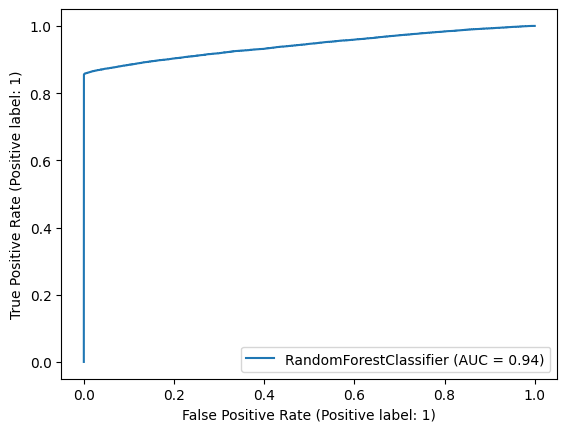

In [97]:
X=df_pca2_lasso.drop(columns=['readmitted']).values
y=df_pca2_lasso['readmitted'].values
X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=0)
clasif = RandomForestClassifier(n_estimators=350, min_samples_split=2,min_samples_leaf=4,max_depth=10).fit(X_train,y_train)

RocCurveDisplay.from_estimator(
   clasif, X_test, y_test)

plt.show()


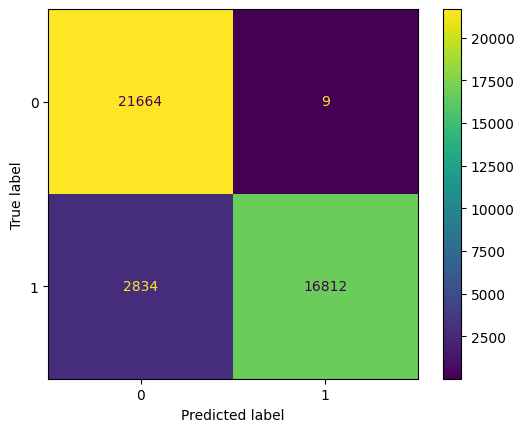

In [98]:
predictions = clasif.predict(X_test)
cm = confusion_matrix(y_test, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()